In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# IMPORT

In [ ]:
import time
import pickle
import numpy as np
import pandas as pd
from typing import Tuple
from collections import deque
import copy
from scipy.special import softmax
import random
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# 환경

In [ ]:
class Environment:
    def __init__(self, gridworld_size:Tuple, num_mine:int):

        self.gridworld_size = gridworld_size
        self.nrow, self.ncol = self.gridworld_size
        self.num_mine = num_mine
        self.totalcnt = 0

        # 그리드월드의 좌표(튜플)의 리스트
        self.points = []
        for i in range(self.nrow):
            for j in range(self.ncol):
                self.points.append((i,j))

        self.num_actions = len(self.points)

        self.reward_dict = {'mine': -8, 'empty':1, 'clear':5}

        # 지뢰 랜덤으로 배정
        self.mine_points = random.sample(self.points, self.num_mine)

        # 그리드 월드 rendering (지뢰: 'M')
        self.gridworld = np.full(shape=(self.nrow, self.ncol), fill_value=".")
        for x,y in self.mine_points:
            self.gridworld[x,y] = 'M'

        # 지뢰 = True인 맵
        self.mine_bool = (self.gridworld=='M')

        # 주변 지뢰 개수를 표시한 맵 (지뢰 위치: -1)
        self.map_answer = np.zeros(self.gridworld_size)

        for x,y in self.points:
            cnt = self.check_mine((x,y))
            self.map_answer[x,y] = cnt


        # state 맵
        self.present_state = np.full((self.nrow, self.ncol), -2) # BFS로 탐색하지 않은 부분을 -2로 초기화


    def check_mine(self, coord:Tuple):

        directions = [(-1, 0), (1, 0), (0, -1), (0, 1),
                  (-1, -1), (-1, 1), (1, -1), (1, 1)]
        x, y = coord
        result = 0

        if self.mine_bool[x,y]:
            result = -1

        else:
            for dx, dy in directions:
                nx, ny = x + dx, y + dy
                if 0 <= nx < self.nrow and 0 <= ny < self.ncol:
                    if self.mine_bool[nx, ny]:
                        result += 1
        return int(result)



    def bfs_minesweeper(self, clicked_point:Tuple):

        queue = deque([clicked_point])
        directions = [(-1, 0), (1, 0), (0, -1), (0, 1),
                    (-1, -1), (-1, 1), (1, -1), (1, 1)]

        result = self.present_state.copy()
        switch_cnt=0

        while queue:
            x, y = queue.popleft()
            if result[x, y]!=-2:
                continue
            result[x, y] = self.map_answer[x, y]
            switch_cnt+=1
            if self.map_answer[x,y] == 0:
                for dx, dy in directions:
                    nx, ny = x + dx, y + dy
                    if 0 <= nx < self.nrow and 0 <= ny < self.ncol and not result[nx, ny]!=-2:
                        queue.append((nx, ny))
        self.totalcnt += 1

        return result, switch_cnt


    def gridworld_reset(self):

        self.gridworld = np.full(shape=(self.nrow, self.ncol), fill_value=".")
        for x,y in self.mine_points:
            self.gridworld[x,y] = 'M'

        # 지뢰 = True인 맵
        self.mine_bool = (self.gridworld=='M')

        # 주변 지뢰 개수를 표시한 맵 (지뢰 위치: -1)
        self.map_answer = np.zeros(self.gridworld_size)
        for x,y in self.points:
            cnt = self.check_mine((x,y))
            self.map_answer[x,y] = cnt

        self.present_state = np.full((self.nrow, self.ncol), -2)
        self.totalcnt = 0


    def move_mine(self, action:Tuple):

        empty_points = list(set(self.points) - set(self.mine_points))
        new_mine = random.sample(empty_points, 1)

        self.mine_points.remove(action)
        self.mine_points.append(new_mine[0])

        self.gridworld_reset()


    def step(self, action:Tuple):

        x, y = action
        flag=True

        # 첫번째 action인 경우
        if np.count_nonzero(self.present_state==-2) == self.nrow*self.ncol :
            if action in self.mine_points:
                # 만약 start 좌표에 지뢰가 있는 경우 옮기기
                flag=False
                self.move_mine(action)


        # action에 따라 계산된 state
        next_state, switch_cnt = self.bfs_minesweeper(action)

        # 현재 위치 업데이트, 경로 추가
        self.present_state = next_state.copy()

        # ======
        # reward

        clear = done = False
        if action in self.mine_points:
            # 지뢰 밟은 경우 -> 지뢰찾기 실패
            # 음수의 보상과 함께 에피소드 종료
            reward = self.reward_dict['mine']
            done = True

        elif np.count_nonzero(self.present_state==-2) == self.num_mine :
            reward = self.reward_dict['clear']
            clear = True # 성공했는지 여부 판단을 위해
            done = True

        else :
            reward = self.reward_dict['empty']

            pred = 0
            directions = [(-1, 0), (1, 0), (0, -1), (0, 1),
                    (-1, -1), (-1, 1), (1, -1), (1, 1)]

            for dx, dy in directions:
                nx, ny = x + dx, y + dy
                if 0 <= nx < self.nrow and 0 <= ny < self.ncol and self.present_state[nx, ny]!=-2:
                    pred+=1

            if pred > 0 :
                reward = self.reward_dict['empty'] * 3

            else:
                reward = self.reward_dict['empty']
            done = False


        return next_state, reward, done, clear


    def reset(self):
        # 지뢰 랜덤으로 배정
        self.mine_points = random.sample(self.points, self.num_mine)
        self.gridworld_reset()
        self.totalcnt = 0


    def render(self):
        render_state = np.full(shape=(self.nrow, self.ncol), fill_value=".")

        for (i,j) in self.points:
            if self.present_state[i,j] == -2:
                continue
            elif self.present_state[i,j] == -1:
                render_state[i,j] = "M"
            else:
                render_state[i,j] = self.present_state[i,j]

        render_state = pd.DataFrame(render_state)
        render_state = render_state.style.applymap(self.render_color)
        display(render_state)


    def render_answer(self):
        render_state = np.full(shape=(self.nrow, self.ncol), fill_value=".")

        for (i,j) in self.points:
            if self.map_answer[i,j] == -1:
                render_state[i,j] = "M"
            else:
                render_state[i,j] = str(self.map_answer[i,j])

        render_state = pd.DataFrame(render_state)
        render_state = render_state.style.applymap(self.render_color)
        display(render_state)


    def render_color(self, var):
        color = {'0':'black', '1':"skyblue", '2':'lightgreen', '3':'red', '4':'violet', '5':'brown',
                 '6':'turquoise', '7':'grey', '8':'black', 'M':'white', '.':'black'}
        return f"color: {color[var]}"

    def train_reset(self, samples:list):
        self.mine_points = random.sample(samples, 1)
        self.gridworld_reset()


# CONFIG

In [ ]:
MEM_SIZE = 50000
MEM_SIZE_MIN = 1000

BATCH_SIZE = 64
GAMMA = 0.1 #gamma


LEARN_MAX = 0.005
LEARN_MIN = 0.00005
LEARN_EPOCH = 2500
LEARN_DECAY = 0.99


EPSILON = 0.9997
EPSILON_DECAY = 0.9997
EPSILON_MIN = 0.001

CONV_UNITS = 64
DENSE_UNITS = 512
UPDATE_TARGET_EVERY = 5

EPISODES = 60000
PRINT_EVERY=100
SAVE_EVERY=1000

# Net

In [ ]:
class DQN_Net(nn.Module):
    def __init__(self, state, action_size, conv_units=64):
        super().__init__()
        self.state_size = len(state) * len(state)
        # 합성곱 층 정의
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=conv_units, kernel_size=(3,3), bias=False, padding=1)
        self.bn1 = nn.BatchNorm2d(conv_units)
        self.bn2 = nn.BatchNorm2d(conv_units)

        self.conv2 = nn.Conv2d(in_channels=conv_units, out_channels=conv_units, kernel_size=(3,3), bias=False, padding=1)

        self.conv3 = nn.Conv2d(in_channels=conv_units, out_channels=conv_units, kernel_size=(3,3), bias=False, padding=1)

        self.conv4 = nn.Conv2d(in_channels=conv_units, out_channels=conv_units, kernel_size=(3,3), bias=False, padding=1)

        self.fc1 = nn.Linear(5184, action_size)
    def forward(self, x):
        # 순전파
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn1(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))

        # flatten
        x = x.view(-1, 5184)  # 배치 크기에 맞게 데이터를 평탄화

        # 완전 연결층
        x = self.fc1(x)

        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Agent

In [ ]:
from torch.optim.lr_scheduler import StepLR

class DQN_Agent:
    def __init__(self, state_size, action, num_mine, model=None):
        self.num_mine = num_mine
        self.state_size = state_size
        self.memory = deque(maxlen=MEM_SIZE)
        self.action = torch.tensor(action)
        self.epsilon = EPSILON
        self.n = state_size[0]


        # model, target model gpu 올리고 초기화
        self.model = DQN_Net(state_size, len(action)).to(device)
        self.target_model = DQN_Net(state_size, len(action)).to(device)
        self.update_target_model()
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=LEARN_MAX)


    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def append_sample(self, state, action_param, reward, next_state, done, clear):
        self.memory.append((state, action_param[0] * self.n + action_param[1], reward, next_state, done, clear))

    # 입실론 탐욕 정책으로 행동 선택
    def get_action(self, state):
        state = torch.tensor(state)
        if np.random.rand() <= self.epsilon:  # 무작위 탐색
            valid_indices = (state == -2).nonzero(as_tuple=True)

            rand_idx = np.random.randint(len(valid_indices[0]))
            x, y = valid_indices[0][rand_idx].item(), valid_indices[1][rand_idx].item()

            return x, y

        else:
            state = state.unsqueeze(0).unsqueeze(0).to(dtype=torch.float).to(device)

            with torch.no_grad():
                q_values = self.model(state).flatten()

                flat = state.squeeze(0).flatten()
                mask = (flat == -2).float()

                masked_q_values = q_values * mask
                masked_q_values[mask == 0] = float('-inf')

                max_q_value, action_idx = torch.max(masked_q_values, dim=-1)

                x = action_idx // self.n
                y = action_idx % self.n

                self.action = [item for item in self.action if item != (x, y)]
                return x, y

    # 리플레이 메모리에서 무작위로 추출한 배치로 모델 학습
    def train_model(self):

        if len(self.memory) < MEM_SIZE_MIN:
            return

        self.batch_size = min(BATCH_SIZE, len(self.memory))
        mini_batch = random.sample(self.memory, self.batch_size)


        states = torch.tensor([sample[0] for sample in mini_batch], dtype=torch.float).to(device)
        actions = torch.tensor([sample[1] for sample in mini_batch], dtype=torch.long).to(device)
        rewards = torch.tensor([sample[2] for sample in mini_batch], dtype=torch.float).to(device)
        next_states = torch.tensor([sample[3] for sample in mini_batch], dtype=torch.float).to(device)
        dones = torch.tensor([sample[4] for sample in mini_batch], dtype=torch.float).to(device)
        clears = torch.tensor([sample[5] for sample in mini_batch], dtype=torch.bool).to(device)

        states = states.unsqueeze(1).to(device)
        next_states = next_states.unsqueeze(1).to(device)

        self.model.train()
        self.target_model.eval()

        predicts = self.model(states) # (64, 81)
        one_hot_action= F.one_hot(actions, self.n * self.n) # [64,81]
        predicts = torch.sum(one_hot_action*predicts, axis=1) # [64] 각 데이터의 action 에 해당하는 q value


        with torch.no_grad():
            next_q_values = self.target_model(next_states).flatten(1)
            flat_next_states = next_states.squeeze(1).flatten(1)
            valid_mask = (flat_next_states == -2).float()

            valid_next_q_values = next_q_values * valid_mask
            valid_next_q_values[valid_mask == 0] = float('-inf')
            max_valid_q_values, _ = torch.max(valid_next_q_values, dim=-1)
            target_q_values = rewards + (torch.ones_like(dones) - dones) * GAMMA * max_valid_q_values

        loss = F.mse_loss (predicts, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


        # 엡실론 감소
        self.epsilon = self.epsilon * EPSILON_DECAY
        self.epsilon = max(self.epsilon, EPSILON_MIN)

        return loss


# Train

In [ ]:
grid_size = (9, 9)
num_mines = 10

env = Environment(grid_size, num_mines)

agent = DQN_Agent(grid_size,  env.points, num_mines)

clears=0
rewards = []


rewards_list = []
clear_list = []
cnt_list = []
loss_list = []

ave_rewards_list = []
ave_clear_list = []
ave_count_list = []
ave_loss_list = []

mid_rewards_list = []
mid_clear_list = []
mid_cnt_list = []
mid_loss_list = []

lr_list = []

for episode in range(EPISODES):
    env.reset()
    state = env.present_state.copy()
    done = False
    clear = False
    total_reward = 0
    cnt = 0
    loss = 0
    agent.action=env.points.copy()
    loss_cnt=0
    loss_arr=[]
    # print(episode)
    while not done:
        action = agent.get_action(state)
        cnt+=1
        next_state, reward, done, clear = env.step(action)
        agent.append_sample(state, action, reward, next_state, done, clear)
        state = next_state.copy()

        total_reward += reward

        if len(agent.memory) > MEM_SIZE_MIN:
            loss = agent.train_model()
            loss = loss.item()
            loss_arr.append(loss)
            loss_cnt+=1
        if done or clear:
            if clear:
                clears+=1
            break

    rewards.append(total_reward)

    # 평가지표
    rewards_list.append(total_reward)
    ave_rewards_list.append(np.mean(rewards_list[-PRINT_EVERY*10:]))
    mid_rewards_list.append(np.median(rewards_list[-PRINT_EVERY*10:]))

    clear_list.append(clear)
    ave_clear_list.append(np.mean(clear_list[-PRINT_EVERY*10:]))
    mid_clear_list.append(np.median(clear_list[-PRINT_EVERY*10:]))

    cnt_list.append(cnt)
    ave_count_list.append(np.mean(cnt_list[-PRINT_EVERY*10:]))
    mid_cnt_list.append(np.median(cnt_list[-PRINT_EVERY*10:]))

    loss_list.append(loss)
    ave_loss_list.append(np.mean(loss_list[-PRINT_EVERY*10:]))
    mid_loss_list.append(np.median(loss_list[-PRINT_EVERY*10:]))

    lr_list.append(agent.optimizer.param_groups[0]['lr'])
    # lr 조절
    if (episode+1) % LEARN_EPOCH == 0:
        lr = agent.optimizer.param_groups[0]['lr'] * LEARN_DECAY
        agent.optimizer.param_groups[0]['lr'] = max(lr, LEARN_MIN)
    if ((episode+1) % SAVE_EVERY == 0) or episode+1 == EPISODES:

        # 시각화 저장
        df = pd.DataFrame()
        df['rewards'] = rewards_list
        df['ave_rewards'] = ave_rewards_list
        df['mid_rewards'] = mid_rewards_list
        df['clear'] = clear_list
        df['ave_clear'] = ave_clear_list
        df['mid_clear'] = mid_clear_list
        df['cnt'] = cnt_list
        df['ave_count'] = ave_count_list
        df['mid_count'] = mid_cnt_list
        df['loss'] = loss_list
        df['ave_loss'] = ave_loss_list
        df['mid_loss'] = mid_loss_list
        df['lr'] = lr_list

        with open(f'/content/gdrive/MyDrive/지뢰찾기/experiment1_visualizing_mine_{num_mines}.pkl', 'wb') as f:
            pickle.dump(df, f)


    if (episode+1) % PRINT_EVERY == 0:
        print(f"[{episode+1}/{EPISODES}]", end=" | ")
        print(f"avg clear: {round(np.mean(clear_list[-PRINT_EVERY*10:]), 3)}", end=" | ")
        print(f"cnt: {round(np.mean(cnt_list[-PRINT_EVERY*10:]), 3)}/{round(np.median(cnt_list[-PRINT_EVERY*10:]), 3)}", end=" | ")
        print(f"Reward: {round(np.mean(rewards_list[-PRINT_EVERY*10:]), 3)}/{round(np.median(rewards_list[-PRINT_EVERY*10:]), 3)}", end=" | ")
        print(f"loss: {round(np.mean(loss_list[-PRINT_EVERY*10:]), 3)}/{round(np.median(loss_list[-PRINT_EVERY*10:]),3)}", end=' | ')
        print(f"Epsilon: {round(agent.epsilon, 5)}", end=" | ")
        print(f"lr: {round(agent.optimizer.param_groups[0]['lr'], 5)}")

print("Training completed.")

[100/60000] | avg clear: 0.0 | cnt: 5.23/5.0 | Reward: 11.23/0.0 | loss: 0.0/0.0 | Epsilon: 0.9997 | lr: 0.005
[200/60000] | avg clear: 0.0 | cnt: 5.205/4.0 | Reward: 10.09/-2.0 | loss: 5.742/0.0 | Epsilon: 0.98748 | lr: 0.005
[300/60000] | avg clear: 0.0 | cnt: 5.053/4.0 | Reward: 9.29/-2.0 | loss: 23.5/0.0 | Epsilon: 0.85631 | lr: 0.005
[400/60000] | avg clear: 0.0 | cnt: 5.098/4.0 | Reward: 9.61/-2.0 | loss: 27.563/5.799 | Epsilon: 0.73195 | lr: 0.005
[500/60000] | avg clear: 0.0 | cnt: 5.12/4.0 | Reward: 10.59/-2.0 | loss: 30.914/12.198 | Epsilon: 0.62602 | lr: 0.005
[600/60000] | avg clear: 0.0 | cnt: 5.143/4.0 | Reward: 10.457/-2.0 | loss: 34.731/17.932 | Epsilon: 0.53462 | lr: 0.005
[700/60000] | avg clear: 0.0 | cnt: 5.219/4.0 | Reward: 10.576/-2.0 | loss: 36.597/26.092 | Epsilon: 0.45099 | lr: 0.005
[800/60000] | avg clear: 0.0 | cnt: 5.206/4.0 | Reward: 10.665/-2.0 | loss: 38.591/32.362 | Epsilon: 0.38676 | lr: 0.005
[900/60000] | avg clear: 0.0 | cnt: 5.241/4.0 | Reward: 10.

In [ ]:
torch.save(agent.model.state_dict(), f"/content/gdrive/MyDrive/지뢰찾기/9by9mine3{num_mines}_{EPISODES}_changelearnrate_model_reward")
torch.save(agent.target_model.state_dict(), f"/content/gdrive/MyDrive/지뢰찾기/9by9mine3{num_mines}_{EPISODES}_changelearnrate_target_model_reward_memory")
torch.save(agent.memory, f"/content/gdrive/MyDrive/지뢰찾기/9by9mine3{num_mines}_{EPISODES}_changelearnrate_model_reward_memory")

# Retraining

### 재학습 config

In [ ]:
# 이어서 학습
# CONFIG 수정, EPSILON, LEARN_RATE, EPISODE 수 변경

MEM_SIZE = 50000
MEM_SIZE_MIN = 1000

BATCH_SIZE = 64
GAMMA = 0.1 #gamma


LEARN_MAX = 0.001
LEARN_MIN = 0.0001
LEARN_EPOCH = 10000
LEARN_DECAY = 0.8


EPSILON = 0.001 # 재학습 시킬 때는 EPSILONG 없앰
EPSILON_DECAY = 0.9997
EPSILON_MIN = 0.001

CONV_UNITS = 64
DENSE_UNITS = 512
UPDATE_TARGET_EVERY = 5

EPISODES = 200000
PRINT_EVERY=100
SAVE_EVERY=1000

### 재학습

In [44]:
# 65 만

from torch.optim.lr_scheduler import StepLR

class DQN_Agent:

    def __init__(self, state_size, action, num_mine, model=None):
        self.num_mine = num_mine
        self.state_size = state_size
        self.memory = torch.load(f"/content/gdrive/MyDrive/지뢰찾기/9by9mine3{num_mines}_{EPISODES}_changelearnrate_model_reward_memory_final", map_location = device)
        self.action = torch.tensor(action)
        self.epsilon = EPSILON
        self.n = state_size[0]


        self.model = DQN_Net(state_size, len(action)).to(device)
        self.model.load_state_dict(torch.load(f"/content/gdrive/MyDrive/지뢰찾기/9by9mine3{num_mines}_{EPISODES}_changelearnrate_model_reward_final", map_location = device))
        self.target_model = DQN_Net(state_size, len(action)).to(device)
        self.target_model.load_state_dict(torch.load( f"/content/gdrive/MyDrive/지뢰찾기/9by9mine3{num_mines}_{EPISODES}_changelearnrate_target_model_reward_memory_final", map_location = device))
        self.update_target_model()
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=LEARN_MAX)


    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def append_sample(self, state, action_param, reward, next_state, done, clear):
        self.memory.append((state, action_param[0] * self.n + action_param[1], reward, next_state, done, clear))

    # 입실론 탐욕 정책으로 행동 선택
    def get_action(self, state):
        state = torch.tensor(state)
        if np.random.rand() <= self.epsilon:  # 무작위 탐색
            valid_indices = (state == -2).nonzero(as_tuple=True)

            rand_idx = np.random.randint(len(valid_indices[0]))
            x, y = valid_indices[0][rand_idx].item(), valid_indices[1][rand_idx].item()

            return x, y

        else:
            state = state.unsqueeze(0).unsqueeze(0).to(dtype=torch.float).to(device)

            with torch.no_grad():
                q_values = self.model(state).flatten()

                flat = state.squeeze(0).flatten()
                mask = (flat == -2).float()

                masked_q_values = q_values * mask
                masked_q_values[mask == 0] = float('-inf')

                max_q_value, action_idx = torch.max(masked_q_values, dim=-1)

                x = action_idx // self.n
                y = action_idx % self.n

                self.action = [item for item in self.action if item != (x, y)]
                return x, y

    # 리플레이 메모리에서 무작위로 추출한 배치로 모델 학습
    def train_model(self):

        if len(self.memory) < MEM_SIZE_MIN:
            return

        self.batch_size = min(BATCH_SIZE, len(self.memory))
        mini_batch = random.sample(self.memory, self.batch_size)


        # Remove numpy conversion
        states = torch.tensor([np.array(sample[0]) for sample in mini_batch], dtype=torch.float).to(device)
        actions = torch.tensor([sample[1] for sample in mini_batch], dtype=torch.long).to(device)
        rewards = torch.tensor([(sample[2]) for sample in mini_batch], dtype=torch.float).to(device)
        next_states = torch.tensor([np.array(sample[3]) for sample in mini_batch], dtype=torch.float).to(device)
        dones = torch.tensor([(sample[4]) for sample in mini_batch], dtype=torch.float).to(device)
        clears = torch.tensor([(sample[5]) for sample in mini_batch], dtype=torch.bool).to(device)


         # 상태 텐서 크기 조정: (batch_size, 1, nrow, ncol)
        states = states.unsqueeze(1).to(device)
        next_states = next_states.unsqueeze(1).to(device)

        self.model.train()
        self.target_model.eval()



        # 현재 상태에 대한 Q 값 예측
        predicts = self.model(states) # (64, 81)
        one_hot_action= F.one_hot(actions, self.n * self.n) # [64,81]
        predicts = torch.sum(one_hot_action*predicts, axis=1) # [64] 각 데이터의 action 에 해당하는 q value

        with torch.no_grad():
            next_q_values = self.target_model(next_states).flatten(1)
            flat_next_states = next_states.squeeze(1).flatten(1)
            valid_mask = (flat_next_states == -2).float()


            valid_next_q_values = next_q_values * valid_mask
            valid_next_q_values[valid_mask == 0] = float('-inf')
            max_valid_q_values, _ = torch.max(valid_next_q_values, dim=-1)
            target_q_values = rewards + (torch.ones_like(dones) - dones) * GAMMA * max_valid_q_values

        loss = F.mse_loss (predicts, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


        # 엡실론 감소
        self.epsilon = self.epsilon * EPSILON_DECAY
        self.epsilon = max(self.epsilon, EPSILON_MIN)

        return loss

grid_size = (9, 9)
num_mines = 10

env = Environment(grid_size, num_mines)

agent = DQN_Agent(grid_size,  env.points, num_mines)

clears=0
rewards = []


rewards_list = []
clear_list = []
cnt_list = []
loss_list = []

ave_rewards_list = []
ave_clear_list = []
ave_count_list = []
ave_loss_list = []

mid_rewards_list = []
mid_clear_list = []
mid_cnt_list = []
mid_loss_list = []

lr_list = []

for episode in range(EPISODES):
    env.reset()
    state = env.present_state.copy()
    done = False
    clear = False
    total_reward = 0
    cnt = 0
    loss = 0
    agent.action=env.points.copy()
    loss_cnt=0
    loss_arr=[]

    while not done:
        action = agent.get_action(state)
        cnt+=1
        next_state, reward, done, clear = env.step(action)
        agent.append_sample(state, action, reward, next_state, done, clear)
        state = next_state.copy()

        total_reward += reward

        if len(agent.memory) > MEM_SIZE_MIN:
            loss = agent.train_model()
            loss = loss.item()
            loss_arr.append(loss)
            loss_cnt+=1
        if done or clear:
            if clear:
                clears+=1
            break

    rewards.append(total_reward)

    # 평가지표
    rewards_list.append(total_reward)
    ave_rewards_list.append(np.mean(rewards_list[-PRINT_EVERY*10:]))
    mid_rewards_list.append(np.median(rewards_list[-PRINT_EVERY*10:]))

    clear_list.append(clear)
    ave_clear_list.append(np.mean(clear_list[-PRINT_EVERY*10:]))
    mid_clear_list.append(np.median(clear_list[-PRINT_EVERY*10:]))

    cnt_list.append(cnt)
    ave_count_list.append(np.mean(cnt_list[-PRINT_EVERY*10:]))
    mid_cnt_list.append(np.median(cnt_list[-PRINT_EVERY*10:]))

    loss_list.append(loss)
    ave_loss_list.append(np.mean(loss_list[-PRINT_EVERY*10:]))
    mid_loss_list.append(np.median(loss_list[-PRINT_EVERY*10:]))

    lr_list.append(agent.optimizer.param_groups[0]['lr'])
    # lr 조절
    if (episode+1) % LEARN_EPOCH == 0:
        lr = agent.optimizer.param_groups[0]['lr'] * LEARN_DECAY
        agent.optimizer.param_groups[0]['lr'] = max(lr, LEARN_MIN)
    if ((episode+1) % SAVE_EVERY == 0) or episode+1 == EPISODES:

        # 시각화 저장
        df = pd.DataFrame()
        df['rewards'] = rewards_list
        df['ave_rewards'] = ave_rewards_list
        df['mid_rewards'] = mid_rewards_list
        df['clear'] = clear_list
        df['ave_clear'] = ave_clear_list
        df['mid_clear'] = mid_clear_list
        df['cnt'] = cnt_list
        df['ave_count'] = ave_count_list
        df['mid_count'] = mid_cnt_list
        df['loss'] = loss_list
        df['ave_loss'] = ave_loss_list
        df['mid_loss'] = mid_loss_list
        df['lr'] = lr_list

        torch.save(agent.model.state_dict(), f"/content/gdrive/MyDrive/지뢰찾기/9by9mine3{num_mines}_{EPISODES}_changelearnrate_model_reward_final")
        torch.save(agent.target_model.state_dict(), f"/content/gdrive/MyDrive/지뢰찾기/9by9mine3{num_mines}_{EPISODES}_changelearnrate_target_model_reward_memory_final")
        torch.save(agent.memory, f"/content/gdrive/MyDrive/지뢰찾기/9by9mine3{num_mines}_{EPISODES}_changelearnrate_model_reward_memory_final")

        with open(f'/content/gdrive/MyDrive/지뢰찾기/experiment5_visualizing_mine_{num_mines}_final_20000+.pkl', 'wb') as f:
            pickle.dump(df, f)


    if (episode+1) % PRINT_EVERY == 0:
        print(f"[{episode+1}/{EPISODES}]", end=" | ")
        print(f"avg clear: {round(np.mean(clear_list[-PRINT_EVERY*10:]), 3)}", end=" | ")
        print(f"cnt: {round(np.mean(cnt_list[-PRINT_EVERY*10:]), 3)}/{round(np.median(cnt_list[-PRINT_EVERY*10:]), 3)}", end=" | ")
        print(f"Reward: {round(np.mean(rewards_list[-PRINT_EVERY*10:]), 3)}/{round(np.median(rewards_list[-PRINT_EVERY*10:]), 3)}", end=" | ")
        print(f"loss: {round(np.mean(loss_list[-PRINT_EVERY*10:]), 3)}/{round(np.median(loss_list[-PRINT_EVERY*10:]),3)}", end=' | ')
        print(f"Epsilon: {round(agent.epsilon, 5)}", end=" | ")
        print(f"lr: {round(agent.optimizer.param_groups[0]['lr'], 5)}")

print("Training completed.")

[100/200000] | avg clear: 0.05 | cnt: 9.58/9.0 | Reward: 13.95/11.0 | loss: 68.645/62.922 | Epsilon: 0.001 | lr: 0.001
[200/200000] | avg clear: 0.055 | cnt: 9.545/9.0 | Reward: 13.73/10.5 | loss: 65.651/58.849 | Epsilon: 0.001 | lr: 0.001
[300/200000] | avg clear: 0.05 | cnt: 9.147/8.5 | Reward: 12.383/10.0 | loss: 63.681/57.89 | Epsilon: 0.001 | lr: 0.001
[400/200000] | avg clear: 0.045 | cnt: 9.1/8.5 | Reward: 12.155/10.0 | loss: 65.048/57.89 | Epsilon: 0.001 | lr: 0.001
[500/200000] | avg clear: 0.042 | cnt: 9.246/9.0 | Reward: 12.34/10.0 | loss: 64.211/57.762 | Epsilon: 0.001 | lr: 0.001
[600/200000] | avg clear: 0.048 | cnt: 9.293/9.0 | Reward: 12.575/10.0 | loss: 63.488/57.548 | Epsilon: 0.001 | lr: 0.001
[700/200000] | avg clear: 0.057 | cnt: 9.291/9.0 | Reward: 12.806/10.0 | loss: 62.083/56.744 | Epsilon: 0.001 | lr: 0.001
[800/200000] | avg clear: 0.056 | cnt: 9.191/9.0 | Reward: 12.505/10.0 | loss: 61.754/56.744 | Epsilon: 0.001 | lr: 0.001
[900/200000] | avg clear: 0.054 | 

KeyboardInterrupt: 

# Train 시각화

In [45]:
# 시각화 코드

def visualizing(file):
    with open(file, 'rb') as f:
        df = pickle.load(f)

    fig, axs = plt.subplots(3, 4, figsize=(20, 15), squeeze=False)
    axs[0, 0].plot(df['ave_rewards'], color = 'blue')
    axs[0, 0].set_title("Avg Reward")
    axs[0, 1].plot(df['mid_rewards'], color = 'blue')
    axs[0, 1].set_title("Median Reward")
    axs[0, 2].plot(df['rewards'], color = 'blue')
    axs[0, 2].set_title("Reward")

    axs[1, 0].plot(df['ave_count'], color = 'skyblue')
    axs[1, 0].set_title("Avg Cnt")
    axs[1, 1].plot(df['mid_count'], color = 'skyblue')
    axs[1, 1].set_title("Median Cnt")
    axs[1, 2].plot(df['cnt'], color = 'skyblue')
    axs[1, 2].set_title("Cnt")

    axs[2, 0].plot(df['ave_loss'], color = 'green')
    axs[2, 0].set_title("Avg Loss")
    axs[2, 1].plot(df['mid_loss'], color = 'green')
    axs[2, 1].set_title("Median Loss")
    axs[2, 2].plot(df['loss'], color = 'green')
    axs[2, 2].set_title('Loss')

    axs[0, 3].plot(df['ave_clear'], color = 'red')
    axs[0, 3].set_title("Avg Clear")
    axs[1, 3].plot(df['lr'], color = 'grey')
    axs[1, 3].set_title("Learning Rate")

    plt.show()

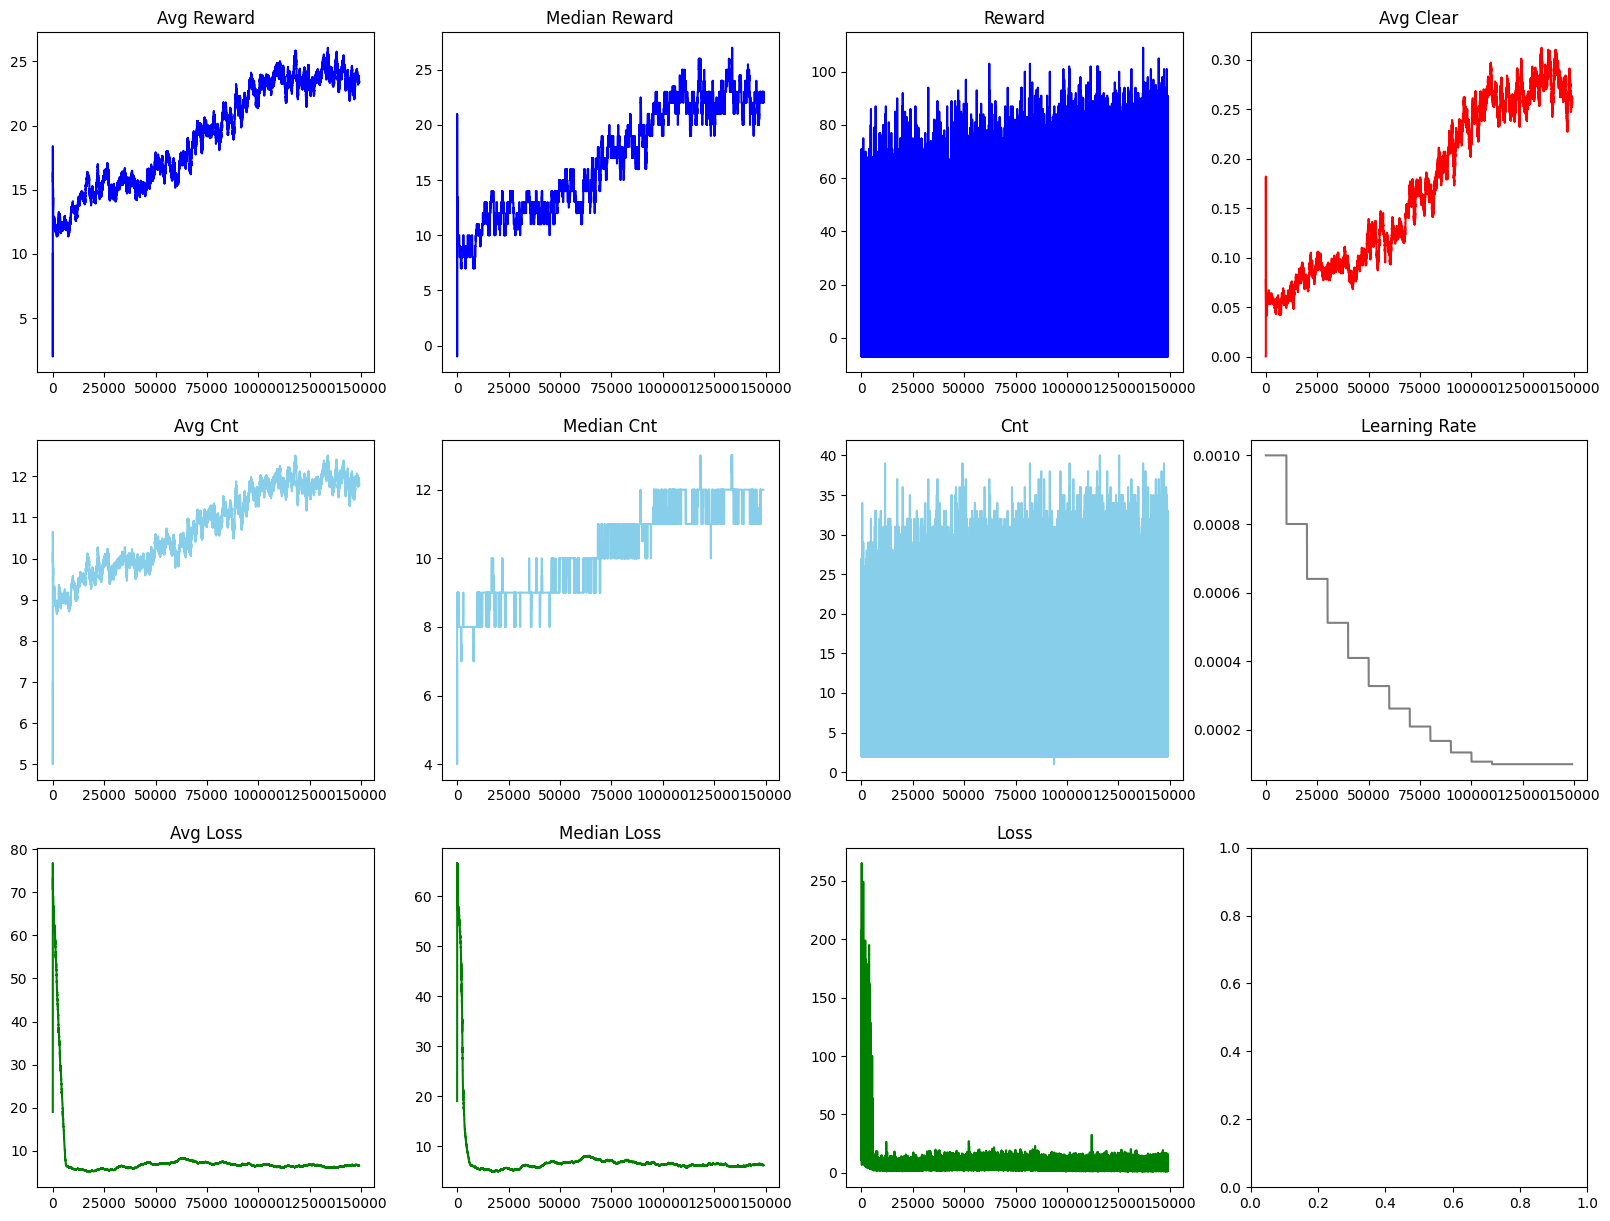

In [46]:
visualizing(f'/content/gdrive/MyDrive/지뢰찾기/experiment5_visualizing_mine_10_final_20000+.pkl')

# Test 시각화

In [47]:
def test_visualizing(file):
    with open(file, 'rb') as f:
        df = pickle.load(f)

    fig, axs = plt.subplots(2, 4, figsize=(20, 10), squeeze=False)
    axs[0, 0].plot(df['avg_rewards'], color = 'blue')
    axs[0, 0].set_title("Avg Reward")
    axs[0, 1].plot(df['mid_rewards'], color = 'blue')
    axs[0, 1].set_title("Median Reward")
    axs[0, 2].plot(df['rewards'], color = 'blue')
    axs[0, 2].set_title("Reward")

    axs[1, 0].plot(df['avg_count'], color = 'skyblue')
    axs[1, 0].set_title("Avg Cnt")
    axs[1, 1].plot(df['mid_count'], color = 'skyblue')
    axs[1, 1].set_title("Median Cnt")
    axs[1, 2].plot(df['cnt'], color = 'skyblue')
    axs[1, 2].set_title("Cnt")

    axs[0, 3].plot(df['avg_clear'], color = 'red')
    axs[0, 3].set_title("Avg Clear")

    plt.show()

In [51]:
class DQN_Agent:
    def __init__(self, state_size, action, num_mine, model=None):
        self.num_mine = num_mine
        self.state_size = state_size
        self.action = torch.tensor(action)  # 한 번 누른건 안 누르게 만든 주머니
        self.epsilon = EPSILON
        self.n = state_size[0]


        self.model = DQN_Net(state_size, len(action)).to(device)
        self.model.load_state_dict(torch.load(f"/content/gdrive/MyDrive/지뢰찾기/9by9mine3{num_mines}_200000_changelearnrate_model_reward_final", map_location = device))

    # 입실론 탐욕 정책으로 행동 선택
    def get_action(self, state):
            state = torch.tensor(state).unsqueeze(0).unsqueeze(0).to(dtype=torch.float).to(device)


            with torch.no_grad():
                q_values = self.model(state).flatten()

                flat = state.squeeze(0).flatten()
                mask = (flat == -2).float()

                masked_q_values = q_values * mask
                masked_q_values[mask == 0] = float('-inf')

                max_q_value, action_idx = torch.max(masked_q_values, dim=-1)

                x = action_idx // self.n
                y = action_idx % self.n

                self.action = [item for item in self.action if item != (x, y)]
                return x, y

In [52]:
grid_size = (9, 9)
num_mines = 10

env = Environment(grid_size, num_mines)

agent = DQN_Agent(grid_size,  env.points, num_mines)

total_clears = 0
clears=0

rewards_list = []
clear_list = []
cnt_list = []

avg_rewards_list = []
avg_clear_list = []
avg_count_list = []

mid_rewards_list = []
mid_clear_list = []
mid_cnt_list = []

EPISODES = 10000

for episode in range(EPISODES):
    # reset
    env.reset()
    state = env.present_state.copy()
    done = False
    clear = False
    total_reward = 0
    cnt = 0
    loss = 0
    agent.action = env.points.copy()

    # 게임 종료까지 반복
    while not done:
        cnt+=1

        state = env.present_state.copy()
        action = agent.get_action(state)
        next_state, reward, done, clear = env.step(action)
        total_reward += reward

        # count 제한: 100
        if cnt > 81:
            done = True

        if done or clear:
            break

    # 평가지표
    rewards_list.append(total_reward)
    avg_rewards_list.append(np.mean(rewards_list[-PRINT_EVERY:]))
    mid_rewards_list.append(np.median(rewards_list[-PRINT_EVERY:]))

    clear_list.append(clear)
    avg_clear_list.append(np.mean(clear_list[-PRINT_EVERY:]))
    mid_clear_list.append(np.median(clear_list[-PRINT_EVERY:]))

    cnt_list.append(cnt)
    avg_count_list.append(np.mean(cnt_list[-PRINT_EVERY:]))
    mid_cnt_list.append(np.median(cnt_list[-PRINT_EVERY:]))

    if ((episode+1) % SAVE_EVERY == 0) or episode+1 == EPISODES:
        # 시각화 저장
        df = pd.DataFrame()
        df['rewards'] = rewards_list
        df['avg_rewards'] = avg_rewards_list
        df['mid_rewards'] = mid_rewards_list
        df['clear'] = clear_list
        df['avg_clear'] = avg_clear_list
        df['mid_clear'] = mid_clear_list
        df['cnt'] = cnt_list
        df['avg_count'] = avg_count_list
        df['mid_count'] = mid_cnt_list

        with open(f'/content/gdrive/MyDrive/test.pkl', 'wb') as f:
            pickle.dump(df, f)


    if (episode+1) % PRINT_EVERY == 0:
        print(f"[{episode+1}/{EPISODES}]", end=" | ")
        print(f"avg clear: {round(np.mean(clear_list[-PRINT_EVERY:]), 3)}", end=" | ")
        print(f"cnt: {round(np.mean(cnt_list[-PRINT_EVERY:]), 3)}/{round(np.median(cnt_list[-PRINT_EVERY:]), 3)}", end=" | ")
        print(f"Reward: {round(np.mean(rewards_list[-PRINT_EVERY:]), 3)}/{round(np.median(rewards_list[-PRINT_EVERY:]), 3)}", end="\n")
        env.render()

print(f"Test completed. avg win rate: {round(np.mean(clear_list), 3)}")

[100/10000] | avg clear: 0.34 | cnt: 12.6/13.0 | Reward: 26.76/26.0


,0,1,2,3,4,5,6,7,8
0,0,0,0,0,0,1,.,1,.
1,0,0,0,0,0,2,.,.,.
2,0,0,0,0,0,2,.,2,.
3,0,1,1,1,0,1,2,.,.
4,0,1,.,1,0,0,1,.,.
5,0,1,.,2,1,2,2,2,1
6,0,1,.,.,M,.,.,2,0
7,0,1,.,.,.,.,.,3,1
8,0,1,.,.,.,.,.,2,.


[200/10000] | avg clear: 0.3 | cnt: 12.52/13.0 | Reward: 26.32/26.0


,0,1,2,3,4,5,6,7,8
0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,1,1,1,1
2,0,0,0,1,2,.,.,2,.
3,0,0,0,2,.,3,.,.,.
4,0,0,0,2,.,.,.,.,.
5,0,0,1,2,.,.,.,.,.
6,1,1,2,.,1,.,.,1,.
7,.,.,.,.,.,.,.,.,.
8,.,.,.,.,.,.,M,1,.


[300/10000] | avg clear: 0.27 | cnt: 12.18/11.0 | Reward: 24.55/18.5


,0,1,2,3,4,5,6,7,8
0,0,0,1,.,3,2,1,0,0
1,0,0,1,2,.,.,1,0,0
2,1,2,1,3,3,3,1,0,0
3,.,2,.,2,.,1,0,0,0
4,1,3,2,3,1,1,0,0,0
5,1,2,.,1,0,0,0,0,0
6,1,.,2,2,1,1,0,0,0
7,1,1,1,1,.,2,1,0,0
8,0,0,0,1,2,.,1,0,0


[400/10000] | avg clear: 0.3 | cnt: 12.14/12.5 | Reward: 25.02/27.0


,0,1,2,3,4,5,6,7,8
0,.,.,.,.,.,.,.,.,.
1,.,.,.,.,.,.,.,.,.
2,.,.,.,.,.,.,.,2,.
3,.,.,.,.,.,.,.,.,.
4,.,.,.,.,.,.,.,.,.
5,.,.,.,.,.,.,.,.,.
6,.,M,.,.,.,.,.,.,.
7,.,.,.,.,.,.,.,.,.
8,.,.,.,.,.,.,.,1,.


[500/10000] | avg clear: 0.3 | cnt: 11.48/11.5 | Reward: 23.26/22.0


,0,1,2,3,4,5,6,7,8
0,.,.,.,.,.,.,.,2,.
1,.,.,.,.,.,3,.,.,.
2,.,.,.,.,.,.,.,1,.
3,.,.,.,.,.,.,.,.,.
4,.,.,.,.,.,.,.,.,.
5,.,.,.,.,.,.,.,.,.
6,.,.,.,.,.,.,.,.,.
7,.,.,.,.,.,.,.,.,.
8,.,.,.,.,.,.,.,M,.


[600/10000] | avg clear: 0.28 | cnt: 13.21/13.0 | Reward: 26.73/27.0


,0,1,2,3,4,5,6,7,8
0,.,1,0,0,0,0,0,0,0
1,.,2,0,0,0,0,0,0,0
2,.,2,1,1,1,0,1,1,1
3,1,.,1,.,2,1,2,.,.
4,1,.,2,1,2,.,2,1,1
5,1,.,1,0,1,1,1,0,0
6,.,.,2,0,0,0,0,0,0
7,M,.,1,0,1,2,2,1,0
8,.,2,1,0,1,.,.,1,0


[700/10000] | avg clear: 0.3 | cnt: 12.1/11.0 | Reward: 24.68/22.5


,0,1,2,3,4,5,6,7,8
0,.,.,.,.,.,.,.,M,.
1,.,.,.,.,.,.,.,.,.
2,.,.,.,.,.,.,.,2,.
3,.,.,.,.,.,.,.,.,.
4,.,.,.,.,.,.,.,1,1
5,.,.,.,.,.,.,.,1,0
6,.,.,.,.,.,.,.,1,0
7,.,1,.,.,2,2,2,1,0
8,.,.,.,.,1,0,0,0,0


[800/10000] | avg clear: 0.26 | cnt: 10.62/10.0 | Reward: 19.86/18.0


,0,1,2,3,4,5,6,7,8
0,.,.,.,1,1,.,1,0,0
1,.,4,.,1,1,1,1,0,0
2,.,2,1,1,0,0,0,0,0
3,2,2,0,0,0,0,0,0,0
4,.,1,0,0,0,0,0,0,0
5,1,2,2,3,2,1,0,0,0
6,1,2,.,.,.,1,0,0,0
7,M,2,2,3,2,1,0,0,0
8,1,1,0,0,0,0,0,0,0


[900/10000] | avg clear: 0.24 | cnt: 11.84/12.0 | Reward: 23.86/22.0


,0,1,2,3,4,5,6,7,8
0,.,.,.,.,.,.,.,M,.
1,.,.,.,.,.,.,.,.,.
2,.,.,.,.,.,.,.,2,.
3,.,.,3,1,1,1,2,.,.
4,.,.,1,0,0,0,1,.,.
5,1,1,1,0,0,0,2,.,.
6,0,0,0,0,0,0,1,.,.
7,0,0,0,0,0,0,1,1,1
8,0,0,0,0,0,0,0,0,0


[1000/10000] | avg clear: 0.25 | cnt: 11.58/12.0 | Reward: 23.05/25.0


,0,1,2,3,4,5,6,7,8
0,.,.,.,.,.,.,1,0,0
1,.,.,.,.,.,.,2,0,0
2,.,.,.,.,.,.,1,1,1
3,.,.,.,.,.,.,.,.,.
4,.,.,.,.,.,.,.,.,.
5,.,.,.,.,.,.,.,.,.
6,.,.,.,.,.,.,.,.,.
7,.,.,.,.,.,.,.,.,.
8,.,M,.,.,.,.,.,.,.


[1100/10000] | avg clear: 0.32 | cnt: 13.28/13.0 | Reward: 28.4/30.0


,0,1,2,3,4,5,6,7,8
0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,2,2,1,0
2,1,1,2,1,3,.,.,1,0
3,.,.,.,.,.,.,.,1,0
4,.,.,.,.,.,.,.,1,1
5,.,.,.,.,.,.,.,.,.
6,.,.,.,.,.,.,.,.,.
7,.,.,.,M,.,.,.,.,.
8,.,.,.,.,.,.,.,.,.


[1200/10000] | avg clear: 0.23 | cnt: 11.6/11.0 | Reward: 22.23/19.0


,0,1,2,3,4,5,6,7,8
0,0,0,0,1,.,1,.,.,.
1,0,0,0,1,1,.,.,1,.
2,0,0,1,1,.,.,.,2,.
3,0,0,1,.,3,.,2,.,.
4,0,0,1,.,.,.,.,.,1
5,0,1,1,1,1,1,1,1,1
6,0,1,.,1,0,0,0,1,.
7,1,2,.,2,1,0,0,1,1
8,.,M,.,.,1,0,0,0,0


[1300/10000] | avg clear: 0.29 | cnt: 11.19/11.0 | Reward: 21.76/20.0


,0,1,2,3,4,5,6,7,8
0,0,1,1,1,0,0,0,0,0
1,2,3,.,1,0,1,1,2,1
2,.,.,2,1,0,1,.,4,.
3,2,2,1,0,0,1,2,.,.
4,0,0,0,0,0,0,1,2,2
5,0,0,0,0,0,0,0,0,0
6,0,0,0,0,1,1,1,0,0
7,0,0,0,0,2,.,2,1,1
8,0,0,0,0,2,.,2,1,.


[1400/10000] | avg clear: 0.31 | cnt: 12.78/12.0 | Reward: 26.77/27.0


,0,1,2,3,4,5,6,7,8
0,0,0,1,2,.,.,.,.,.
1,0,0,2,.,M,.,.,.,.
2,0,0,2,.,.,.,.,2,.
3,0,0,1,2,.,.,.,.,1
4,0,0,0,1,.,.,.,1,.
5,0,0,0,1,1,2,1,.,.
6,0,1,1,1,0,1,.,2,1
7,0,1,.,1,0,1,1,1,0
8,0,1,1,1,0,0,0,0,0


[1500/10000] | avg clear: 0.3 | cnt: 12.38/12.0 | Reward: 25.16/26.0


,0,1,2,3,4,5,6,7,8
0,.,.,.,.,.,.,.,.,.
1,.,.,.,.,.,.,.,.,.
2,.,.,.,.,.,.,.,2,.
3,.,.,.,.,.,.,.,.,.
4,.,.,.,.,.,.,.,.,.
5,.,.,.,.,.,.,.,.,.
6,.,.,.,.,.,.,.,.,.
7,.,.,.,.,.,.,.,.,.
8,.,.,.,.,.,.,.,M,.


[1600/10000] | avg clear: 0.28 | cnt: 12.42/12.5 | Reward: 26.12/24.5


,0,1,2,3,4,5,6,7,8
0,.,M,1,0,1,1,1,0,0
1,.,1,1,0,1,.,1,0,0
2,.,1,1,1,1,1,1,0,0
3,1,2,.,1,0,0,0,1,1
4,.,2,1,1,0,0,0,1,.
5,1,1,0,0,0,0,0,2,2
6,1,1,1,0,0,1,1,2,.
7,1,.,2,1,1,2,.,2,1
8,1,2,.,1,1,.,2,1,0


[1700/10000] | avg clear: 0.33 | cnt: 12.11/12.0 | Reward: 24.88/22.5


,0,1,2,3,4,5,6,7,8
0,1,1,1,.,1,1,1,1,0
1,.,1,1,1,1,1,.,1,0
2,1,2,1,1,0,1,1,1,0
3,1,2,.,1,1,1,1,0,0
4,2,.,3,1,1,.,2,1,1
5,2,.,2,0,2,2,3,.,1
6,1,1,1,0,1,.,2,1,1
7,0,0,0,0,1,1,1,1,1
8,0,0,0,0,0,0,0,1,.


[1800/10000] | avg clear: 0.31 | cnt: 12.17/12.0 | Reward: 25.66/26.0


,0,1,2,3,4,5,6,7,8
0,.,.,.,.,.,.,.,.,.
1,.,.,.,.,.,.,.,.,.
2,.,.,.,.,.,.,.,2,.
3,.,.,.,.,.,.,.,.,.
4,.,.,.,.,.,.,.,.,.
5,.,.,.,.,.,.,.,.,.
6,.,.,.,.,.,.,.,.,.
7,.,.,.,.,.,.,.,.,.
8,.,.,.,.,.,.,.,M,.


[1900/10000] | avg clear: 0.29 | cnt: 11.79/12.0 | Reward: 23.74/24.0


,0,1,2,3,4,5,6,7,8
0,.,1,0,0,0,0,0,1,.
1,.,1,0,1,1,1,0,1,.
2,1,1,0,1,.,1,0,2,.
3,0,0,0,1,1,1,0,2,.
4,0,0,1,1,1,0,0,2,.
5,0,0,1,.,1,0,0,1,1
6,0,0,1,.,1,0,0,0,0
7,0,1,2,.,2,1,0,1,1
8,0,1,.,M,.,1,0,1,.


[2000/10000] | avg clear: 0.26 | cnt: 11.97/10.0 | Reward: 23.25/18.5


,0,1,2,3,4,5,6,7,8
0,.,1,1,.,.,M,.,1,0
1,1,.,.,.,.,2,.,1,0
2,1,1,2,.,.,2,1,1,0
3,0,0,1,.,.,1,0,0,0
4,0,0,1,.,.,2,1,0,0
5,1,2,1,1,.,.,1,0,0
6,.,.,.,2,1,1,2,1,1
7,1,3,.,2,0,0,1,.,1
8,.,1,.,1,0,0,1,1,.


[2100/10000] | avg clear: 0.18 | cnt: 10.87/10.5 | Reward: 19.91/15.0


,0,1,2,3,4,5,6,7,8
0,.,.,.,1,0,0,0,0,0
1,.,.,.,2,2,1,1,0,0
2,.,.,.,.,.,.,1,0,0
3,.,.,.,.,.,2,1,0,0
4,.,.,.,.,.,1,0,0,0
5,.,.,.,1,.,1,1,0,0
6,.,.,.,.,.,.,2,1,1
7,.,.,.,M,.,.,.,.,.
8,.,.,.,.,.,.,.,.,.


[2200/10000] | avg clear: 0.26 | cnt: 12.34/12.0 | Reward: 24.54/24.0


,0,1,2,3,4,5,6,7,8
0,.,.,M,.,.,.,.,1,.
1,.,.,.,.,.,1,.,.,.
2,.,.,.,.,.,.,.,1,.
3,.,.,.,.,.,.,.,.,.
4,.,.,.,.,.,.,.,.,.
5,.,.,.,.,.,.,.,.,.
6,.,.,.,.,.,.,.,.,.
7,.,.,.,.,.,.,.,.,.
8,.,.,.,.,.,.,.,.,.


[2300/10000] | avg clear: 0.25 | cnt: 13.0/13.0 | Reward: 25.85/26.0


,0,1,2,3,4,5,6,7,8
0,0,1,.,.,3,.,1,0,0
1,0,1,3,.,3,1,1,0,0
2,0,0,1,1,1,0,0,0,0
3,0,1,1,1,0,0,0,0,0
4,1,2,.,1,0,0,0,1,1
5,1,.,2,1,0,0,0,1,.
6,1,2,2,1,0,0,1,2,2
7,0,1,.,1,0,0,1,.,2
8,0,1,1,1,0,0,1,.,M


[2400/10000] | avg clear: 0.19 | cnt: 11.23/10.5 | Reward: 21.02/15.5


,0,1,2,3,4,5,6,7,8
0,.,2,.,1,0,0,0,0,0
1,M,.,.,3,3,2,1,0,0
2,1,1,1,.,.,.,1,0,0
3,0,0,1,2,4,3,2,0,0
4,0,0,0,0,1,.,1,0,0
5,1,1,1,0,1,2,2,1,0
6,1,.,1,0,0,1,.,2,1
7,1,1,1,0,0,2,3,.,1
8,0,0,0,0,0,1,.,2,1


[2500/10000] | avg clear: 0.3 | cnt: 12.3/12.5 | Reward: 25.34/27.0


,0,1,2,3,4,5,6,7,8
0,1,1,0,0,0,0,0,0,0
1,.,2,0,0,0,0,0,0,0
2,.,3,1,0,1,1,1,0,0
3,.,.,3,2,3,.,1,0,0
4,3,M,.,.,.,3,1,0,0
5,.,2,2,3,.,2,0,0,0
6,1,1,0,1,1,1,0,0,0
7,0,1,1,1,0,0,0,0,0
8,0,1,.,1,0,0,0,0,0


[2600/10000] | avg clear: 0.29 | cnt: 12.39/11.0 | Reward: 25.62/25.0


,0,1,2,3,4,5,6,7,8
0,.,.,.,.,.,.,.,.,.
1,.,.,.,.,.,.,.,.,.
2,.,.,.,.,.,.,.,2,1
3,.,.,.,.,.,.,2,1,0
4,.,.,.,.,1,1,1,0,0
5,.,.,.,2,1,0,0,0,0
6,M,.,.,.,1,0,0,0,0
7,.,.,.,3,1,0,0,0,0
8,.,.,.,1,0,0,0,0,0


[2700/10000] | avg clear: 0.28 | cnt: 12.77/12.0 | Reward: 26.37/24.5


,0,1,2,3,4,5,6,7,8
0,M,.,.,.,.,.,1,0,0
1,.,.,.,.,.,.,1,1,1
2,.,.,.,.,.,.,.,2,.
3,.,.,.,.,.,.,.,2,1
4,.,.,.,.,.,.,.,1,0
5,.,.,.,.,.,.,.,1,0
6,.,1,.,.,.,.,.,1,0
7,.,.,.,.,.,.,.,2,1
8,.,.,.,.,.,.,.,1,.


[2800/10000] | avg clear: 0.32 | cnt: 12.79/12.5 | Reward: 27.23/28.5


,0,1,2,3,4,5,6,7,8
0,.,1,0,0,0,0,1,.,1
1,.,2,0,0,0,0,1,1,1
2,.,2,0,0,0,0,0,0,0
3,.,3,1,1,0,0,0,0,0
4,.,3,.,1,0,0,0,0,0
5,.,2,1,1,0,0,1,1,1
6,1,1,0,0,0,0,1,M,1
7,1,1,2,2,2,1,1,1,1
8,1,.,2,.,.,1,0,0,0


[2900/10000] | avg clear: 0.2 | cnt: 12.02/12.0 | Reward: 23.06/26.5


,0,1,2,3,4,5,6,7,8
0,0,0,0,2,.,M,.,2,2
1,1,1,1,3,.,3,.,.,.
2,.,1,1,.,2,1,1,3,.
3,1,2,3,3,2,0,0,1,1
4,0,1,.,.,1,0,0,0,0
5,0,1,2,2,1,0,0,0,0
6,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0


[3000/10000] | avg clear: 0.34 | cnt: 13.04/13.0 | Reward: 28.02/30.5


,0,1,2,3,4,5,6,7,8
0,.,M,.,1,0,0,0,1,.
1,.,.,.,2,2,1,1,2,2
2,.,1,1,.,2,.,2,2,.
3,.,.,2,1,2,2,.,2,1
4,2,.,1,0,0,1,1,1,0
5,1,1,1,0,0,0,0,0,0
6,0,0,0,0,0,0,0,1,1
7,0,0,0,0,0,0,0,1,.
8,0,0,0,0,0,0,0,1,1


[3100/10000] | avg clear: 0.26 | cnt: 11.42/11.5 | Reward: 22.44/23.5


,0,1,2,3,4,5,6,7,8
0,0,0,0,0,1,2,.,1,0
1,0,1,1,1,1,.,2,1,0
2,0,1,.,1,2,2,2,0,0
3,0,1,1,1,1,.,1,0,0
4,1,1,0,0,1,2,2,2,1
5,.,1,0,0,0,1,.,3,.
6,1,2,1,1,0,1,1,3,.
7,0,1,.,1,0,0,0,2,2
8,0,1,1,1,0,0,0,1,.


[3200/10000] | avg clear: 0.3 | cnt: 12.11/11.5 | Reward: 24.79/21.0


,0,1,2,3,4,5,6,7,8
0,.,.,1,1,1,1,0,0,0
1,2,3,2,2,.,1,0,0,0
2,0,1,.,2,1,2,1,1,0
3,0,1,1,1,0,1,.,2,1
4,0,0,0,0,0,1,1,2,.
5,1,1,0,0,0,0,1,2,2
6,.,2,0,0,0,1,2,.,1
7,.,2,0,0,0,1,.,2,1
8,1,1,0,0,0,1,1,1,0


[3300/10000] | avg clear: 0.2 | cnt: 11.02/11.0 | Reward: 20.66/19.0


,0,1,2,3,4,5,6,7,8
0,0,0,0,0,0,0,1,.,.
1,0,0,0,0,0,0,1,2,2
2,0,0,1,1,1,0,0,0,0
3,1,1,2,.,1,0,0,0,0
4,1,.,2,1,1,0,0,0,0
5,1,2,3,2,1,0,0,0,0
6,0,1,.,.,1,0,0,0,0
7,0,2,3,3,2,1,2,2,2
8,0,1,.,1,1,.,2,.,.


[3400/10000] | avg clear: 0.22 | cnt: 11.74/11.0 | Reward: 22.24/19.0


,0,1,2,3,4,5,6,7,8
0,.,1,0,1,.,1,0,0,0
1,1,1,0,1,1,1,0,0,0
2,0,0,0,0,0,0,1,1,1
3,0,0,1,1,1,0,1,.,.
4,0,1,2,.,1,0,1,1,1
5,0,1,.,2,1,0,0,0,0
6,1,2,.,1,0,0,0,0,0
7,.,.,.,1,1,1,2,2,1
8,.,.,.,.,.,.,M,.,.


[3500/10000] | avg clear: 0.26 | cnt: 11.96/12.5 | Reward: 23.74/21.5


,0,1,2,3,4,5,6,7,8
0,M,.,.,.,.,.,.,1,.
1,.,.,3,.,.,1,.,.,.
2,.,.,.,.,.,.,.,2,.
3,.,.,.,.,.,.,.,.,.
4,.,.,.,.,.,.,.,.,.
5,.,.,.,.,.,.,.,.,.
6,.,1,.,.,.,.,.,.,.
7,.,.,.,.,.,.,.,.,.
8,1,.,.,.,.,.,.,1,.


[3600/10000] | avg clear: 0.3 | cnt: 12.31/14.0 | Reward: 25.21/29.0


,0,1,2,3,4,5,6,7,8
0,0,0,0,0,0,1,1,1,0
1,0,0,0,0,0,2,.,3,1
2,0,0,0,1,1,4,.,5,.
3,0,0,1,2,.,.,.,.,.
4,1,1,1,.,3,.,2,2,1
5,M,1,1,1,2,.,1,0,0
6,1,1,0,0,1,1,1,0,0
7,0,0,0,0,0,0,0,1,1
8,0,0,0,0,0,0,0,1,.


[3700/10000] | avg clear: 0.26 | cnt: 11.49/11.5 | Reward: 22.95/22.5


,0,1,2,3,4,5,6,7,8
0,.,.,.,.,.,.,.,.,.
1,.,.,.,.,.,.,1,1,1
2,.,.,.,.,.,.,1,0,0
3,.,.,.,.,.,1,1,0,0
4,.,.,.,.,.,1,0,0,0
5,.,.,.,.,.,3,3,2,1
6,.,.,.,.,.,.,.,.,.
7,.,.,.,.,.,2,.,M,.
8,.,.,.,.,.,.,.,.,.


[3800/10000] | avg clear: 0.31 | cnt: 12.09/13.5 | Reward: 24.96/28.0


,0,1,2,3,4,5,6,7,8
0,0,0,0,0,0,0,0,0,0
1,0,1,1,1,1,1,1,1,1
2,1,2,.,.,.,.,.,1,.
3,.,.,.,.,.,2,1,2,.
4,1,1,1,1,1,1,0,1,.
5,0,0,0,0,0,0,1,2,.
6,0,1,1,1,0,0,1,.,.
7,0,1,.,2,1,1,1,2,M
8,0,1,.,.,.,.,.,.,.


[3900/10000] | avg clear: 0.34 | cnt: 12.83/13.0 | Reward: 27.17/27.5


,0,1,2,3,4,5,6,7,8
0,0,1,.,1,0,0,0,0,0
1,1,2,.,1,0,0,0,0,0
2,.,M,2,1,0,0,0,0,0
3,.,.,.,2,1,1,0,0,0
4,.,3,1,2,.,1,0,0,0
5,1,2,1,2,1,1,0,0,0
6,0,1,.,1,0,0,1,1,1
7,0,1,1,1,1,1,3,.,.
8,0,0,0,0,1,.,.,.,2


[4000/10000] | avg clear: 0.3 | cnt: 12.09/11.5 | Reward: 24.43/24.0


,0,1,2,3,4,5,6,7,8
0,0,0,0,0,0,1,1,2,.
1,0,0,1,1,1,1,.,2,1
2,1,1,2,.,1,2,2,2,0
3,1,.,2,1,1,1,.,1,0
4,1,1,1,0,0,1,2,2,1
5,0,0,0,0,0,1,2,.,1
6,1,1,0,1,1,2,.,2,1
7,.,1,0,1,.,3,2,2,0
8,1,1,0,1,1,2,.,1,0


[4100/10000] | avg clear: 0.26 | cnt: 11.7/11.0 | Reward: 22.74/21.0


,0,1,2,3,4,5,6,7,8
0,0,0,0,0,0,0,0,0,0
1,0,1,1,1,0,0,0,0,0
2,1,2,.,1,0,0,0,0,0
3,.,.,2,1,0,0,0,0,0
4,2,.,2,1,0,0,0,1,1
5,1,2,.,1,0,0,0,1,.
6,.,3,3,3,1,1,0,2,2
7,1,.,.,.,.,1,0,1,.
8,.,.,.,M,2,1,0,1,1


[4200/10000] | avg clear: 0.24 | cnt: 11.94/11.5 | Reward: 23.68/24.0


,0,1,2,3,4,5,6,7,8
0,.,.,M,.,.,.,.,2,.
1,.,.,.,.,.,1,.,.,.
2,.,.,.,.,.,.,.,1,.
3,.,.,.,.,.,.,.,.,.
4,.,.,.,.,.,.,.,.,.
5,.,.,.,.,.,.,.,.,.
6,.,.,.,.,.,.,.,.,.
7,.,.,.,.,.,.,.,.,.
8,.,.,.,.,.,.,.,.,.


[4300/10000] | avg clear: 0.31 | cnt: 12.25/12.0 | Reward: 24.94/24.0


,0,1,2,3,4,5,6,7,8
0,.,.,.,.,.,.,1,0,0
1,.,.,.,.,2,.,2,0,0
2,.,.,.,.,.,.,3,1,1
3,.,.,.,.,.,.,.,.,.
4,.,.,.,.,.,.,.,.,.
5,.,.,.,.,.,.,.,.,.
6,.,.,.,.,.,.,.,.,.
7,.,.,.,.,.,.,.,.,.
8,.,.,.,.,.,M,.,.,.


[4400/10000] | avg clear: 0.24 | cnt: 10.82/10.5 | Reward: 20.2/20.5


,0,1,2,3,4,5,6,7,8
0,1,1,0,0,0,0,0,2,.
1,.,1,1,1,1,0,0,2,.
2,1,2,2,.,1,0,0,1,1
3,0,2,.,3,1,0,0,1,1
4,1,3,.,2,0,0,0,1,.
5,1,.,2,1,0,0,0,1,1
6,1,1,1,0,0,0,0,1,1
7,0,0,0,0,0,0,0,2,.
8,0,0,0,0,0,0,0,2,.


[4500/10000] | avg clear: 0.25 | cnt: 11.86/11.0 | Reward: 23.53/21.0


,0,1,2,3,4,5,6,7,8
0,.,.,.,.,.,.,.,.,.
1,.,.,.,.,.,.,.,.,.
2,.,.,.,.,.,.,.,2,.
3,.,.,.,.,.,.,.,.,.
4,.,.,.,.,.,.,.,.,.
5,.,.,.,.,.,.,.,.,.
6,.,.,.,.,.,.,.,.,.
7,.,.,.,.,.,.,.,.,.
8,.,.,.,.,.,.,.,M,.


[4600/10000] | avg clear: 0.23 | cnt: 10.96/10.0 | Reward: 20.21/18.0


,0,1,2,3,4,5,6,7,8
0,0,0,1,.,1,0,0,0,0
1,1,1,2,1,2,1,1,1,1
2,.,.,1,0,1,.,1,1,.
3,1,2,2,2,2,2,1,1,1
4,0,1,.,.,.,.,1,0,0
5,0,1,2,.,.,.,1,0,0
6,0,0,1,.,.,.,1,0,0
7,0,0,1,.,.,.,1,1,1
8,0,0,1,M,.,.,1,.,.


[4700/10000] | avg clear: 0.21 | cnt: 11.07/10.0 | Reward: 20.82/14.0


,0,1,2,3,4,5,6,7,8
0,0,0,0,0,0,0,0,1,.
1,0,0,0,0,0,0,0,1,1
2,0,0,1,1,2,1,1,0,0
3,0,1,2,.,2,.,2,1,0
4,0,1,.,2,2,.,.,2,1
5,1,2,2,2,.,2,2,.,.
6,.,.,1,.,.,.,2,.,.
7,1,1,1,1,2,.,1,.,M
8,0,0,0,0,1,.,1,.,.


[4800/10000] | avg clear: 0.19 | cnt: 10.78/10.5 | Reward: 19.71/17.5


,0,1,2,3,4,5,6,7,8
0,.,1,0,1,.,.,.,1,.
1,.,1,0,1,.,1,.,.,.
2,1,1,1,1,.,.,.,1,.
3,0,0,1,.,.,.,.,.,.
4,0,0,2,.,.,.,.,.,.
5,1,1,1,.,.,.,.,.,.
6,.,1,1,.,.,.,.,.,.
7,.,.,.,.,.,.,.,.,.
8,M,1,.,.,.,.,.,.,.


[4900/10000] | avg clear: 0.29 | cnt: 12.28/12.5 | Reward: 24.81/26.0


,0,1,2,3,4,5,6,7,8
0,.,.,.,.,.,.,.,M,.
1,.,.,.,.,.,.,.,.,.
2,.,.,.,.,.,.,.,1,.
3,.,.,.,.,.,.,.,.,.
4,.,.,.,.,.,.,.,.,.
5,.,.,.,.,.,.,.,.,.
6,.,.,.,.,.,.,.,.,.
7,.,.,.,.,.,.,.,.,.
8,.,.,.,.,.,.,.,.,.


[5000/10000] | avg clear: 0.33 | cnt: 12.82/14.0 | Reward: 27.07/29.5


,0,1,2,3,4,5,6,7,8
0,.,.,M,.,.,.,.,1,.
1,.,.,.,.,.,2,.,.,.
2,.,.,.,.,.,.,.,1,.
3,.,.,.,.,.,.,.,.,.
4,.,.,.,.,.,.,.,.,.
5,.,.,.,.,.,.,.,.,.
6,.,.,.,.,.,.,.,.,.
7,.,.,.,.,.,.,.,.,.
8,.,.,.,.,.,.,.,.,.


[5100/10000] | avg clear: 0.29 | cnt: 11.8/12.0 | Reward: 23.83/26.0


,0,1,2,3,4,5,6,7,8
0,1,1,1,0,1,1,1,0,0
1,2,.,2,0,1,.,1,1,1
2,2,.,2,0,1,1,1,1,.
3,1,1,1,0,0,0,0,1,1
4,1,1,1,0,0,0,0,0,0
5,1,.,2,2,1,1,0,0,0
6,2,3,.,2,.,3,2,1,0
7,1,.,2,2,2,.,.,1,0
8,1,1,1,0,1,2,2,1,0


[5200/10000] | avg clear: 0.25 | cnt: 11.82/11.0 | Reward: 23.19/22.0


,0,1,2,3,4,5,6,7,8
0,1,.,2,3,.,2,0,0,0
1,1,1,2,.,.,2,0,0,0
2,0,0,1,2,2,1,0,0,0
3,0,0,0,0,0,0,1,1,1
4,0,0,0,0,0,0,1,.,1
5,0,1,1,1,0,1,3,3,2
6,0,2,.,2,0,1,.,.,2
7,0,2,.,2,0,1,2,3,.
8,0,1,1,1,0,0,0,1,1


[5300/10000] | avg clear: 0.3 | cnt: 10.64/10.5 | Reward: 20.5/18.0


,0,1,2,3,4,5,6,7,8
0,.,.,M,.,.,.,.,1,.
1,.,.,.,.,.,1,.,.,.
2,.,.,.,.,.,.,.,1,.
3,.,.,.,.,.,.,.,.,.
4,.,.,.,.,.,.,.,.,.
5,.,.,.,.,.,.,.,.,.
6,.,.,.,.,.,.,.,.,.
7,.,.,.,.,.,.,.,.,.
8,.,.,.,.,.,.,.,.,.


[5400/10000] | avg clear: 0.21 | cnt: 11.58/11.5 | Reward: 22.13/21.0


,0,1,2,3,4,5,6,7,8
0,0,1,M,2,.,1,0,0,0
1,0,1,.,3,2,1,0,0,0
2,0,1,2,.,1,1,1,1,0
3,0,1,.,3,2,2,.,1,0
4,0,1,1,3,.,3,1,1,0
5,0,0,0,3,.,3,0,0,0
6,0,0,0,2,.,2,0,0,0
7,0,0,0,2,2,2,0,1,1
8,0,0,0,1,.,1,0,1,.


[5500/10000] | avg clear: 0.3 | cnt: 11.73/13.0 | Reward: 23.47/25.5


,0,1,2,3,4,5,6,7,8
0,1,1,2,.,2,.,1,0,0
1,2,.,3,1,2,1,1,0,0
2,3,.,2,0,0,0,1,1,1
3,.,2,1,0,0,0,1,.,1
4,1,1,0,0,0,1,3,3,2
5,0,0,0,1,1,2,.,.,1
6,0,0,0,1,.,2,2,2,1
7,0,0,0,2,2,2,0,0,0
8,0,0,0,1,.,1,0,0,0


[5600/10000] | avg clear: 0.3 | cnt: 11.85/10.0 | Reward: 23.81/15.5


,0,1,2,3,4,5,6,7,8
0,1,1,1,0,0,1,1,1,0
1,2,.,2,1,1,2,.,1,0
2,3,.,2,1,.,2,1,1,0
3,.,2,1,1,1,1,0,0,0
4,2,2,2,1,1,0,0,0,0
5,1,.,3,.,1,0,1,1,1
6,1,2,.,2,1,0,1,.,1
7,0,1,1,1,0,0,1,2,2
8,0,0,0,0,0,0,0,1,.


[5700/10000] | avg clear: 0.25 | cnt: 12.2/12.0 | Reward: 23.63/21.0


,0,1,2,3,4,5,6,7,8
0,0,0,0,0,0,0,0,0,0
1,0,1,1,1,0,0,0,0,0
2,0,2,.,2,0,0,0,0,0
3,1,3,.,2,1,1,1,0,0
4,2,.,5,.,2,.,1,0,0
5,2,.,.,.,2,1,1,0,0
6,1,2,4,3,2,1,1,1,0
7,0,0,1,.,1,1,.,2,1
8,0,0,1,1,1,.,1,.,M


[5800/10000] | avg clear: 0.25 | cnt: 12.35/11.0 | Reward: 24.74/22.0


,0,1,2,3,4,5,6,7,8
0,1,.,1,0,0,1,1,1,0
1,1,1,1,0,0,2,.,2,0
2,0,0,0,0,0,2,.,2,0
3,0,1,1,2,1,2,2,2,1
4,0,1,.,3,.,2,2,.,1
5,0,1,2,.,3,.,2,1,1
6,0,0,2,2,3,1,1,0,0
7,0,0,2,.,2,0,0,0,0
8,0,0,2,.,2,0,0,0,0


[5900/10000] | avg clear: 0.28 | cnt: 12.51/12.0 | Reward: 25.83/24.5


,0,1,2,3,4,5,6,7,8
0,.,.,.,2,0,1,.,1,0
1,.,.,.,2,0,1,1,1,0
2,.,.,.,1,0,0,0,0,0
3,.,.,.,2,1,1,0,0,0
4,.,.,M,.,.,1,0,0,0
5,.,.,.,.,.,2,1,0,0
6,.,.,.,.,.,.,1,0,0
7,.,.,.,.,.,.,2,0,0
8,.,.,.,.,.,.,1,0,0


[6000/10000] | avg clear: 0.25 | cnt: 12.11/12.0 | Reward: 24.42/22.5


,0,1,2,3,4,5,6,7,8
0,1,2,1,1,0,0,0,1,1
1,.,2,.,1,0,0,0,1,M
2,2,3,2,2,1,0,0,1,1
3,.,1,1,.,1,0,0,0,0
4,1,1,1,1,1,0,0,0,0
5,0,0,0,0,0,0,0,0,0
6,0,0,0,1,2,2,2,1,1
7,1,1,0,1,.,.,3,.,1
8,.,1,0,1,2,3,.,2,.


[6100/10000] | avg clear: 0.3 | cnt: 12.3/11.5 | Reward: 25.12/25.0


,0,1,2,3,4,5,6,7,8
0,0,1,.,2,1,1,.,1,0
1,0,1,2,.,1,1,1,1,0
2,0,0,1,1,1,0,0,0,0
3,1,1,1,0,0,0,0,0,0
4,2,.,2,1,0,0,0,0,0
5,.,3,.,1,1,1,2,1,1
6,1,2,1,1,1,.,2,.,1
7,0,1,1,1,1,1,3,2,2
8,0,1,.,1,0,0,1,.,1


[6200/10000] | avg clear: 0.34 | cnt: 12.33/11.5 | Reward: 25.45/23.0


,0,1,2,3,4,5,6,7,8
0,0,0,0,1,.,.,.,1,.
1,0,0,0,2,.,2,.,.,.
2,0,1,1,3,.,.,.,1,.
3,0,2,.,.,.,.,.,.,.
4,0,2,.,.,.,.,.,.,.
5,0,1,.,.,.,.,.,.,.
6,1,1,.,.,.,.,M,.,.
7,.,.,1,.,.,.,.,.,.
8,1,.,.,.,.,.,.,.,.


[6300/10000] | avg clear: 0.16 | cnt: 11.05/10.5 | Reward: 19.19/16.5


,0,1,2,3,4,5,6,7,8
0,.,2,.,2,.,1,0,0,0
1,1,2,1,2,1,1,0,0,0
2,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,1
4,0,0,0,0,0,0,0,1,.
5,1,1,1,0,0,1,1,2,1
6,1,.,1,0,0,1,.,1,0
7,3,4,3,1,0,1,2,2,1
8,.,.,.,1,0,0,1,.,1


[6400/10000] | avg clear: 0.3 | cnt: 11.74/12.0 | Reward: 23.1/24.5


,0,1,2,3,4,5,6,7,8
0,.,.,.,.,.,.,.,M,.
1,.,.,.,.,.,.,.,.,.
2,.,.,.,.,.,.,.,2,.
3,.,.,.,.,.,.,.,.,.
4,.,.,.,.,.,.,.,.,.
5,.,.,.,.,.,.,.,.,.
6,.,1,.,.,.,.,.,.,.
7,.,.,.,.,.,.,.,.,.
8,.,.,.,.,.,.,.,1,.


[6500/10000] | avg clear: 0.36 | cnt: 13.23/14.0 | Reward: 28.41/30.0


,0,1,2,3,4,5,6,7,8
0,.,.,.,.,2,0,0,0,0
1,.,1,M,.,2,0,0,0,0
2,.,.,.,.,2,0,0,0,0
3,.,.,2,.,2,0,0,0,0
4,.,.,3,.,2,0,1,1,1
5,.,.,.,.,1,0,1,.,.
6,1,1,1,1,1,1,1,1,.
7,0,0,0,2,.,2,1,1,1
8,0,0,0,2,.,2,.,.,.


[6600/10000] | avg clear: 0.38 | cnt: 12.74/12.0 | Reward: 28.2/28.5


,0,1,2,3,4,5,6,7,8
0,0,0,0,0,0,0,0,1,.
1,0,1,2,2,1,0,0,1,1
2,0,1,.,.,2,1,0,1,1
3,0,1,2,3,.,1,0,1,.
4,0,0,0,1,1,1,1,2,2
5,0,0,1,1,1,0,1,.,1
6,0,0,1,.,1,0,1,1,1
7,0,0,1,1,1,1,2,.,2
8,0,0,0,0,0,1,.,M,.


[6700/10000] | avg clear: 0.3 | cnt: 12.81/13.0 | Reward: 26.31/27.5


,0,1,2,3,4,5,6,7,8
0,0,1,.,.,.,M,.,1,0
1,0,1,.,2,.,2,.,2,1
2,1,2,1,1,.,.,.,2,.
3,.,1,0,1,1,2,1,.,.
4,1,1,0,1,.,.,.,1,.
5,.,1,0,1,1,2,1,1,.
6,.,1,0,0,0,0,1,.,.
7,1,1,0,0,0,0,1,.,1
8,0,0,0,0,0,0,1,1,.


[6800/10000] | avg clear: 0.2 | cnt: 12.4/12.0 | Reward: 24.42/21.0


,0,1,2,3,4,5,6,7,8
0,.,1,0,0,0,0,0,0,0
1,2,2,0,0,0,0,0,0,0
2,.,1,0,0,0,1,1,1,0
3,1,1,0,1,1,3,.,2,0
4,0,0,1,2,.,3,.,3,1
5,0,0,1,.,3,3,2,2,.
6,0,0,1,1,2,.,2,2,2
7,0,0,0,0,2,2,3,.,1
8,0,0,0,0,1,.,2,1,1


[6900/10000] | avg clear: 0.33 | cnt: 11.35/11.0 | Reward: 22.92/21.0


,0,1,2,3,4,5,6,7,8
0,0,1,.,.,.,2,0,0,0
1,0,1,2,4,.,2,0,0,0
2,0,0,0,2,2,2,1,1,1
3,0,0,0,1,.,1,1,.,1
4,0,0,0,1,1,1,1,1,1
5,0,0,0,0,0,0,0,1,1
6,1,1,0,0,0,1,1,2,.
7,.,1,0,1,1,2,.,2,1
8,1,1,0,1,.,2,1,1,0


[7000/10000] | avg clear: 0.28 | cnt: 12.51/11.5 | Reward: 25.05/21.0


,0,1,2,3,4,5,6,7,8
0,0,1,1,1,1,2,.,1,0
1,0,1,.,1,1,.,2,1,0
2,0,1,1,1,2,2,2,0,0
3,0,0,0,0,1,.,1,0,0
4,0,0,0,0,1,1,1,0,0
5,1,1,0,0,0,0,0,0,0
6,.,2,0,0,0,0,1,1,1
7,.,2,0,1,1,2,2,.,2
8,1,1,0,1,.,2,.,3,.


[7100/10000] | avg clear: 0.26 | cnt: 12.38/11.5 | Reward: 24.8/22.0


,0,1,2,3,4,5,6,7,8
0,0,0,1,.,1,0,1,2,.
1,0,0,1,1,1,0,1,.,2
2,0,0,0,0,0,0,2,2,2
3,0,0,0,0,0,0,1,.,1
4,1,1,0,0,0,1,2,2,1
5,.,1,1,1,1,1,.,1,0
6,1,1,2,M,.,.,.,1,0
7,0,0,3,.,.,.,.,1,1
8,0,0,2,.,.,.,.,1,.


[7200/10000] | avg clear: 0.38 | cnt: 12.12/12.0 | Reward: 26.38/26.5


,0,1,2,3,4,5,6,7,8
0,.,.,2,.,.,.,.,1,.
1,2,.,.,.,.,1,.,.,.
2,.,.,.,2,.,.,.,1,.
3,.,1,.,2,.,.,.,.,M
4,.,.,.,.,.,.,.,.,.
5,.,.,2,1,1,1,1,2,.
6,1,1,1,0,0,0,0,1,1
7,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0


[7300/10000] | avg clear: 0.24 | cnt: 12.28/11.5 | Reward: 24.5/20.5


,0,1,2,3,4,5,6,7,8
0,.,.,M,.,.,.,.,.,.
1,.,.,.,.,.,2,1,1,1
2,.,.,.,.,.,.,1,0,0
3,.,.,.,.,.,.,3,1,1
4,.,.,.,.,.,.,.,.,.
5,.,.,.,.,.,.,.,1,.
6,.,.,.,.,.,.,.,.,.
7,.,.,.,.,.,.,.,.,.
8,.,.,.,.,.,.,.,.,.


[7400/10000] | avg clear: 0.24 | cnt: 12.2/12.0 | Reward: 23.86/24.5


,0,1,2,3,4,5,6,7,8
0,.,.,.,.,.,.,.,.,.
1,.,.,.,.,.,.,.,.,.
2,.,.,.,.,.,.,.,2,.
3,.,.,.,.,.,.,.,.,.
4,.,.,.,.,.,.,.,.,.
5,.,.,.,.,.,.,.,.,.
6,.,.,.,.,.,.,.,.,.
7,.,.,.,.,.,.,.,.,.
8,.,.,.,.,.,.,.,M,.


[7500/10000] | avg clear: 0.29 | cnt: 12.95/13.5 | Reward: 27.08/28.0


,0,1,2,3,4,5,6,7,8
0,0,1,3,.,3,1,0,1,.
1,0,1,.,.,.,1,0,1,1
2,0,2,3,4,2,1,0,0,0
3,0,1,.,2,1,0,1,1,1
4,0,1,2,.,1,0,1,.,1
5,0,0,1,1,2,1,2,1,1
6,0,0,0,0,1,.,1,0,0
7,0,0,0,0,2,2,2,0,0
8,0,0,0,0,1,.,1,0,0


[7600/10000] | avg clear: 0.3 | cnt: 12.51/12.0 | Reward: 25.85/24.0


,0,1,2,3,4,5,6,7,8
0,1,1,1,0,1,1,1,0,0
1,1,.,1,0,1,.,1,0,0
2,1,1,1,1,2,2,1,0,0
3,1,1,1,1,.,1,0,1,1
4,1,.,1,1,1,1,1,2,.
5,1,2,2,1,0,0,1,.,2
6,0,1,.,1,0,1,2,3,2
7,0,1,1,1,1,2,.,2,.
8,0,0,0,0,1,.,2,2,1


[7700/10000] | avg clear: 0.31 | cnt: 13.03/14.0 | Reward: 27.22/28.5


,0,1,2,3,4,5,6,7,8
0,0,0,1,.,1,0,0,1,1
1,0,0,1,M,2,1,0,1,.
2,0,0,1,2,.,2,1,2,1
3,0,0,1,2,2,2,.,1,0
4,1,1,1,.,1,1,1,1,0
5,.,1,1,1,1,0,0,0,0
6,2,2,0,1,1,2,1,1,0
7,.,1,0,2,.,3,.,1,0
8,1,1,0,2,.,3,1,1,0


[7800/10000] | avg clear: 0.28 | cnt: 11.59/12.0 | Reward: 22.97/23.0


,0,1,2,3,4,5,6,7,8
0,0,0,0,0,0,0,0,1,.
1,1,2,2,1,0,0,0,1,1
2,1,.,.,1,0,0,0,1,1
3,1,2,2,1,0,0,0,2,M
4,1,1,0,0,0,0,0,2,.
5,.,2,2,1,1,1,1,2,1
6,2,.,2,.,1,1,.,1,0
7,1,1,2,1,1,1,2,2,1
8,0,0,0,0,0,0,1,.,.


[7900/10000] | avg clear: 0.26 | cnt: 11.4/10.0 | Reward: 21.94/19.0


,0,1,2,3,4,5,6,7,8
0,.,.,.,.,.,.,.,M,.
1,.,.,.,.,.,.,.,.,.
2,.,.,.,.,.,.,.,1,.
3,.,.,.,.,.,.,.,.,.
4,.,.,.,.,.,.,.,.,.
5,.,.,.,.,.,.,.,.,.
6,.,.,.,.,.,.,.,.,.
7,.,.,.,.,.,.,.,.,.
8,.,.,.,.,.,.,.,.,.


[8000/10000] | avg clear: 0.25 | cnt: 12.39/13.0 | Reward: 24.26/21.5


,0,1,2,3,4,5,6,7,8
0,0,0,1,1,2,1,1,0,0
1,1,1,1,.,2,.,1,0,0
2,.,2,3,2,3,1,1,0,0
3,2,.,3,.,2,0,0,0,0
4,1,1,3,.,2,0,0,0,0
5,0,0,1,2,3,2,1,0,0
6,0,0,0,1,.,.,1,0,0
7,0,0,0,1,3,4,3,1,0
8,0,0,0,0,1,.,.,1,0


[8100/10000] | avg clear: 0.25 | cnt: 12.17/12.0 | Reward: 24.44/23.0


,0,1,2,3,4,5,6,7,8
0,1,.,1,0,1,1,2,2,2
1,1,1,1,0,1,.,2,.,.
2,0,0,0,0,1,1,2,2,2
3,0,1,1,2,1,1,0,0,0
4,0,1,.,3,.,3,1,1,0
5,0,1,1,3,.,3,.,2,1
6,0,0,0,1,1,2,1,2,.
7,1,1,1,0,0,0,0,1,1
8,1,.,1,0,0,0,0,0,0


[8200/10000] | avg clear: 0.17 | cnt: 10.42/9.0 | Reward: 18.47/13.5


,0,1,2,3,4,5,6,7,8
0,M,2,.,1,1,1,0,0,0
1,.,.,3,3,.,1,0,0,0
2,.,3,.,.,2,1,0,0,0
3,.,2,2,2,1,0,0,0,0
4,1,1,0,0,0,0,0,0,0
5,.,2,1,1,0,0,0,0,0
6,.,3,.,2,1,0,0,0,0
7,1,.,3,.,1,0,0,0,0
8,1,1,2,1,1,0,0,0,0


[8300/10000] | avg clear: 0.33 | cnt: 12.25/13.0 | Reward: 25.7/28.5


,0,1,2,3,4,5,6,7,8
0,1,1,0,0,0,0,0,0,0
1,.,1,0,0,1,1,1,1,1
2,2,2,1,0,1,.,2,2,.
3,1,.,1,0,1,1,2,.,2
4,1,1,1,0,0,0,1,1,1
5,0,0,0,0,0,0,1,2,2
6,1,1,0,0,0,0,1,.,.
7,.,1,1,1,1,1,2,3,2
8,1,1,1,.,1,1,.,1,0


[8400/10000] | avg clear: 0.28 | cnt: 11.95/10.0 | Reward: 24.25/18.0


,0,1,2,3,4,5,6,7,8
0,.,2,.,1,2,.,3,.,1
1,1,2,1,1,2,.,3,1,1
2,0,0,0,0,1,1,1,0,0
3,0,0,0,1,1,2,1,1,0
4,0,0,0,2,.,3,.,1,0
5,0,0,0,2,.,3,1,1,0
6,0,0,1,2,3,2,1,0,0
7,0,0,1,.,2,.,1,0,0
8,0,0,1,1,2,1,1,0,0


[8500/10000] | avg clear: 0.29 | cnt: 12.82/13.0 | Reward: 26.53/27.0


,0,1,2,3,4,5,6,7,8
0,.,.,.,.,.,.,.,M,.
1,.,.,.,.,.,.,.,.,.
2,.,.,.,.,.,.,.,1,.
3,.,.,.,.,.,.,.,.,.
4,.,.,.,.,.,.,.,.,.
5,.,.,.,.,.,.,.,.,.
6,.,.,.,.,.,.,.,.,.
7,.,.,.,.,.,.,.,.,.
8,.,.,.,.,.,.,.,.,.


[8600/10000] | avg clear: 0.29 | cnt: 12.24/12.5 | Reward: 25.13/24.0


,0,1,2,3,4,5,6,7,8
0,0,2,.,3,.,1,0,0,0
1,0,2,.,3,1,1,0,0,0
2,0,2,2,2,0,0,0,0,0
3,1,2,.,1,0,0,0,0,0
4,1,.,3,2,1,0,0,0,0
5,1,1,2,.,1,0,0,0,0
6,0,1,2,2,1,0,0,1,1
7,0,1,.,1,1,2,2,2,.
8,0,1,1,1,1,.,.,2,1


[8700/10000] | avg clear: 0.25 | cnt: 11.63/11.0 | Reward: 22.86/23.0


,0,1,2,3,4,5,6,7,8
0,.,.,.,.,.,.,.,M,.
1,.,.,.,.,.,.,.,.,.
2,.,.,.,.,.,.,.,1,.
3,.,.,.,.,.,.,.,.,.
4,.,.,.,.,.,.,.,.,.
5,.,.,.,.,.,.,.,.,.
6,.,.,.,.,.,.,.,.,.
7,.,.,.,.,.,.,.,.,.
8,.,.,.,.,.,.,.,.,.


[8800/10000] | avg clear: 0.24 | cnt: 13.17/13.0 | Reward: 27.29/28.5


,0,1,2,3,4,5,6,7,8
0,.,.,.,1,0,1,.,1,0
1,.,.,.,2,0,1,.,2,1
2,2,.,M,1,0,1,1,2,.
3,2,.,2,1,0,0,0,1,1
4,.,1,1,1,1,0,0,0,0
5,1,1,1,.,1,0,0,0,0
6,0,0,1,1,1,0,0,0,0
7,1,1,0,0,0,0,0,0,0
8,.,1,0,0,0,0,0,0,0


[8900/10000] | avg clear: 0.24 | cnt: 12.48/13.5 | Reward: 25.1/27.0


,0,1,2,3,4,5,6,7,8
0,1,1,0,0,0,0,0,0,0
1,.,1,1,2,2,1,0,0,0
2,1,1,1,.,.,2,1,1,1
3,0,0,1,.,.,.,.,M,.
4,1,1,1,1,.,.,.,2,.
5,.,.,1,1,.,1,.,.,.
6,1,1,1,1,.,.,.,.,.
7,0,0,1,2,.,1,.,.,1
8,0,0,1,.,.,.,.,.,.


[9000/10000] | avg clear: 0.28 | cnt: 11.8/11.0 | Reward: 24.0/20.0


,0,1,2,3,4,5,6,7,8
0,0,0,0,0,0,0,1,.,.
1,1,1,0,0,0,1,2,4,3
2,.,1,0,0,0,1,.,2,.
3,1,1,0,0,0,1,2,3,2
4,1,1,0,0,0,0,1,.,1
5,.,1,0,0,0,1,2,3,2
6,1,1,0,0,0,1,.,2,.
7,0,0,0,1,1,2,1,2,1
8,0,0,0,1,.,1,0,0,0


[9100/10000] | avg clear: 0.47 | cnt: 14.24/13.0 | Reward: 33.05/36.0


,0,1,2,3,4,5,6,7,8
0,0,0,1,.,1,0,0,0,0
1,1,1,1,1,1,0,0,0,0
2,.,1,0,0,0,1,1,1,0
3,1,1,0,0,1,2,.,1,0
4,1,1,0,0,1,.,3,2,0
5,.,2,1,1,1,2,.,2,1
6,2,3,.,1,0,1,3,.,2
7,1,.,2,1,0,0,2,.,2
8,1,1,1,0,0,0,1,1,1


[9200/10000] | avg clear: 0.24 | cnt: 11.1/11.0 | Reward: 20.34/20.0


,0,1,2,3,4,5,6,7,8
0,.,.,.,.,.,.,.,M,.
1,.,.,.,.,.,.,.,.,.
2,.,.,.,.,.,.,.,1,.
3,.,.,.,.,.,.,.,.,.
4,.,.,.,.,.,.,.,.,.
5,.,.,.,.,.,.,.,.,.
6,.,.,.,.,.,.,.,.,.
7,.,.,.,.,.,.,.,.,.
8,.,.,.,.,.,.,.,.,.


[9300/10000] | avg clear: 0.27 | cnt: 12.27/12.0 | Reward: 23.82/19.0


,0,1,2,3,4,5,6,7,8
0,0,1,.,1,0,1,1,1,0
1,0,1,1,1,1,2,.,1,0
2,0,0,0,0,1,M,.,2,0
3,0,0,0,0,1,3,.,3,1
4,0,0,0,0,0,2,.,3,.
5,0,0,0,0,0,2,2,3,.
6,0,0,0,0,0,1,.,3,2
7,0,0,1,1,1,1,2,.,.
8,0,0,1,.,1,0,1,2,2


[9400/10000] | avg clear: 0.38 | cnt: 12.52/12.5 | Reward: 27.24/29.0


,0,1,2,3,4,5,6,7,8
0,.,1,0,1,.,.,.,.,.
1,.,1,0,1,2,3,.,2,.
2,1,1,0,0,0,1,.,2,.
3,0,0,0,0,1,1,.,.,.
4,0,0,0,0,1,.,.,.,.
5,0,0,1,1,2,1,.,M,.
6,0,0,1,.,1,1,.,2,.
7,0,0,2,2,2,1,.,.,.
8,0,0,1,.,1,1,.,1,.


[9500/10000] | avg clear: 0.24 | cnt: 11.91/12.0 | Reward: 23.49/23.0


,0,1,2,3,4,5,6,7,8
0,.,.,M,2,1,0,1,.,1
1,1,2,.,.,2,0,1,1,1
2,2,.,4,.,2,0,0,0,0
3,2,.,4,2,3,2,2,1,0
4,2,2,2,.,2,.,.,1,0
5,.,1,1,1,2,2,2,1,0
6,1,1,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0


[9600/10000] | avg clear: 0.3 | cnt: 12.14/12.0 | Reward: 25.32/26.0


,0,1,2,3,4,5,6,7,8
0,.,2,0,1,.,2,.,1,0
1,.,2,0,1,1,2,1,1,0
2,2,2,1,0,0,0,0,0,0
3,1,.,2,1,1,0,0,0,0
4,1,1,2,.,1,0,1,1,1
5,0,0,1,1,2,2,3,.,1
6,0,0,0,0,1,.,.,2,1
7,0,0,0,1,2,3,2,1,0
8,0,0,0,1,.,1,0,0,0


[9700/10000] | avg clear: 0.3 | cnt: 12.67/11.0 | Reward: 26.09/23.0


,0,1,2,3,4,5,6,7,8
0,.,.,.,.,.,.,.,1,.
1,.,.,.,.,.,.,.,.,.
2,.,.,.,.,.,.,.,2,.
3,.,.,.,.,.,.,.,.,.
4,.,.,.,.,.,3,2,2,.
5,.,.,.,.,.,1,0,1,.
6,.,M,.,3,2,1,0,1,1
7,.,.,.,2,0,0,0,0,0
8,.,.,.,1,0,0,0,0,0


[9800/10000] | avg clear: 0.29 | cnt: 11.02/11.0 | Reward: 21.59/23.0


,0,1,2,3,4,5,6,7,8
0,0,0,1,2,3,.,1,0,0
1,0,0,1,.,.,2,1,1,1
2,0,0,1,2,2,1,0,1,M
3,0,0,0,0,0,0,0,1,1
4,1,1,0,0,0,0,1,2,2
5,.,2,1,1,0,0,1,.,.
6,2,3,.,2,1,0,1,2,2
7,.,.,3,.,1,0,0,0,0
8,1,.,2,1,1,0,0,0,0


[9900/10000] | avg clear: 0.29 | cnt: 11.34/10.0 | Reward: 22.53/17.5


,0,1,2,3,4,5,6,7,8
0,.,1,0,0,0,0,0,0,0
1,.,1,0,0,0,0,0,0,0
2,.,1,0,0,0,0,0,0,0
3,.,3,2,2,1,1,0,1,1
4,M,.,.,2,.,1,0,1,.
5,.,.,4,3,1,1,0,1,1
6,2,3,.,1,0,1,1,1,0
7,0,1,1,1,0,1,.,1,0
8,0,0,0,0,0,1,1,1,0


[10000/10000] | avg clear: 0.28 | cnt: 11.43/11.0 | Reward: 22.41/19.5


,0,1,2,3,4,5,6,7,8
0,0,1,.,M,.,.,.,1,0
1,1,3,.,.,.,.,.,1,0
2,.,.,.,4,.,.,.,2,0
3,1,2,1,2,.,.,.,1,0
4,0,0,0,1,2,3,2,1,0
5,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0


Test completed. avg win rate: 0.278


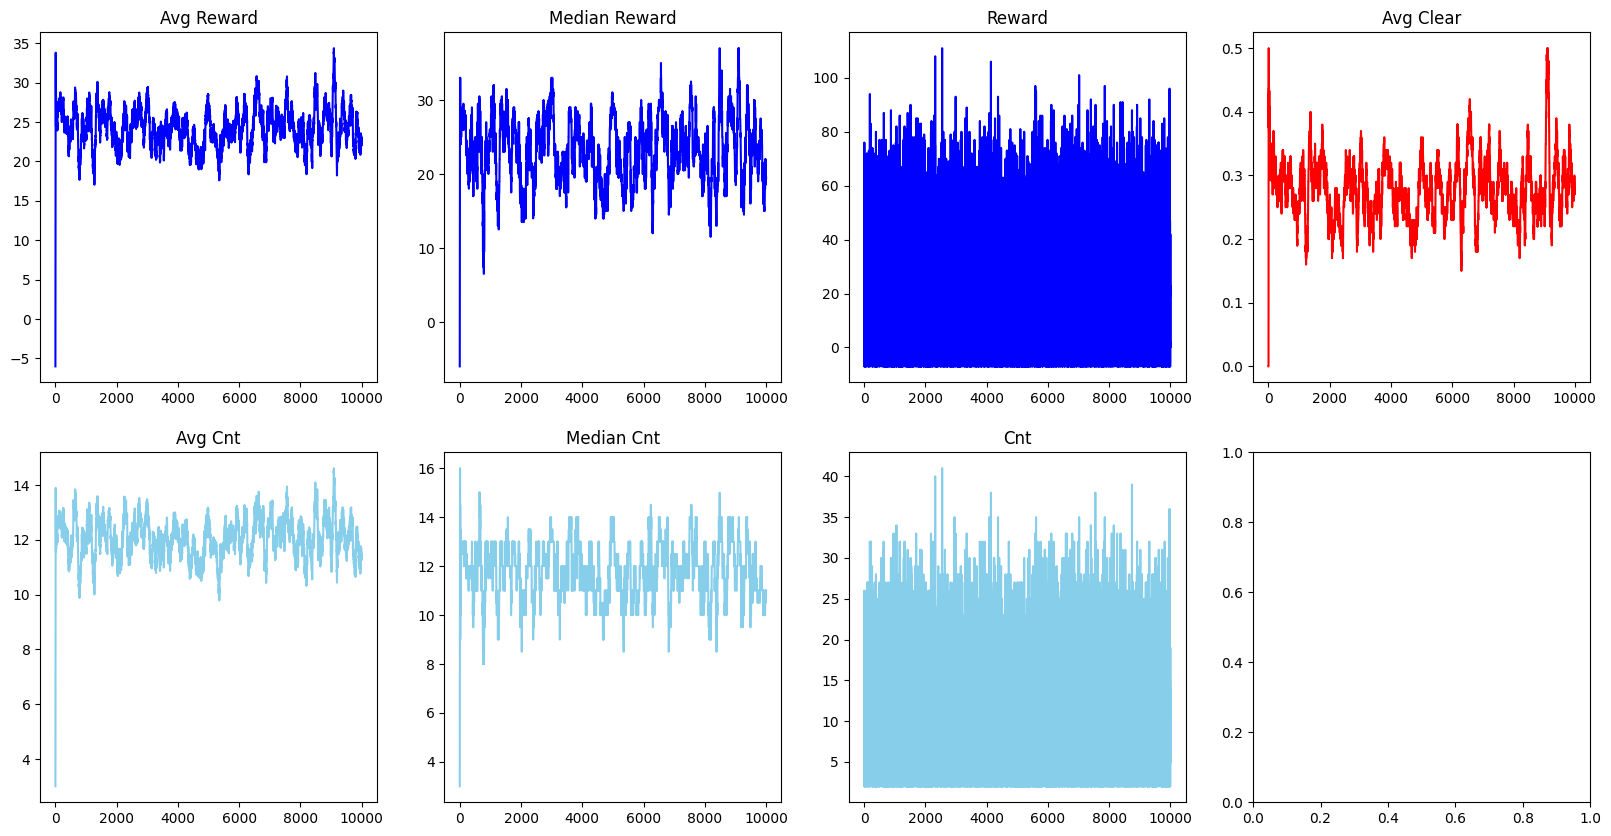

In [54]:
test_visualizing(f'/content/gdrive/MyDrive/test.pkl')